# Нейросетевой алгоритм анализа нарушений сердечного ритма на основе матрицы признаков ЭКГ
---

Чаще всего при анализе ЭКГ сигнала исследуются закономерности между подряд идущими последовательностями. В данной работе будет исследоваться сама последовательность, в частности ее графическое представление. Будет использовано преимущество сверточных нейронных сетей в анализе изображений.

Библиотеки

In [1]:
import glob
import os
import numpy as np
import pandas as pd
from typing import List, Sequence, Any, Callable, Dict
import wfdb
import math
import random
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.io
from scipy.stats import *
from scipy.integrate import simps, trapz
from scipy import signal

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 5)

## Загрузка и отбор сигналов
Работаем с базами данных:
- MIT-BIH Atrial Fibrillation
- MIT-BIH Arrhythmia
- MGH/MF Waveform

In [131]:
def read_txt(path: str) -> List[str]:
    '''Построчное чтение *.txt файла'''
    file = open(path, 'r')
    lines = file.readlines()
    file.close()
    
    return lines

def create_marks(marks_path: str) -> List[int] and List[str]:
    '''Создание массива позиций R-пиков и массива меток класса
    для каждого сердечного сокращения для одной записи.
    
    Parameters
    ----------
    marks_path : str
        Абсолютная ссылка на файл аннотации *.txt.

    Returns
    -------
    marks : List[int]
        Номера отсчетов R-пиков.
        
    classes : List[str]
        Метки класса.
    '''
    lines_txt = read_txt(marks_path)
    
    marks = []
    classes = []
    
    # Борьба со сложной разметкой файлов
    for i in range(1, len(lines_txt)):
        if len(lines_txt[i].split('     ')) == 2:
            marks.append(int(lines_txt[i].split('     ')[0].split(' ')[-1]))
            classes.append(lines_txt[i].split('     ')[1].split(' ')[0])
            
        elif len(lines_txt[i].split('     ')) == 3:
            marks.append(int(lines_txt[i].split('     ')[1].split(' ')[-1]))
            classes.append(lines_txt[i].split('     ')[2].split(' ')[0])
            
    return marks, classes

In [132]:
def create_marks_afdb(marks_path: str, bounds: List[List[int]]) -> List[int] and List[str]:
    '''Создание массива позиций R-пиков и массива меток класса
    для каждого сердечного сокращения для одной записи
    из MIT-BIH Atrial Fibrillation.
    
    Parameters
    ----------
    marks_path : str
        Абсолютная ссылка на файл аннотации *.txt.
        
    bounds : List[List[int]]
        Границы участков сигнала с фибрилляцией предсердий.

    Returns
    -------
    marks : List[int]
        Номера отсчетов R-пиков.
        
    classes : List[str]
        Метки класса.
    '''
    lines_txt = read_txt(marks_path)
    
    marks = []
    classes = []
    
    for i in range(1, len(lines_txt)):
        if len(lines_txt[i].split('     ')) == 2:
            mark_i = int(lines_txt[i].split('     ')[0].split(' ')[-1])
            flag = 0
            
            # Проверка условия попадания в интервалы
            for bound in bounds:
                if mark_i >= bound[0] and mark_i <= bound[1]:
                    flag = 1
            if flag == 1:
                marks.append(mark_i)
                classes.append('AFIB')
                
        elif len(lines_txt[i].split('     ')) == 3:
            mark_i = int(lines_txt[i].split('     ')[1].split(' ')[-1])
            flag = 0
            
            for bound in bounds:
                if mark_i >= bound[0] and mark_i <= bound[1]:
                    flag = 1
            if flag == 1:
                marks.append(mark_i)
                classes.append('AFIB')
            
    return marks, classes

### MIT-BIH Atrial Fibrillation 
Список имен файлов сигналов и аннотаций, сортировка.

In [133]:
# Список всех файлов AFDB
directory_afdb = 'C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/afdb'
files_afdb = os.listdir(directory_afdb)

# Фильтрация и сортировка списков по суффиксу
def extension_filter(filenames_array: List[str], endswith: str) -> List[str]:
    '''Возвращает отфильтрованный по расширению файла список.'''
    
    return sorted(list(filter(lambda x: x.endswith(endswith), filenames_array)))

# Сигналы
filename_ecg_afdb = extension_filter(files_afdb, '.mat')

# Параметры сигнала
filename_desc_afdb = extension_filter(files_afdb, 'desc.txt')

# Разметка эпизодов разных типов фибрилляции
filename_fib_afdb = extension_filter(files_afdb, 'fib.txt')

# Разметка для каждого сокращения
filename_annotation_afdb = extension_filter(files_afdb, '.txt')
filename_annotation_afdb = list(set(filename_annotation_afdb).difference(set(filename_desc_afdb)))
filename_annotation_afdb = sorted(list(set(filename_annotation_afdb).difference(set(filename_fib_afdb))))

Список имен записей с номерами каналов II отведения. Выбраны вручную, опираясь на уровень шумов и количество эпизодов патологий.

In [134]:
afdb_channels = [['04048',0],['04746',1],['04936',1],['05121',1],['05261',0],['06995',0],['07879',1],['08455',1]]

Загрузка сигналов AFDB с помощью библиотеки physionet

In [135]:
def load_signals(array: List, channels: List, path: str) -> List:
    '''Загрузка сигналов ЭКГ второго отведения.
    
    Parameters
    ----------
    array: List
        Массив для добавления сигналов.
        
    channels: List
        Список параметров сигналов - имя, канал для II отведения.
    
    path: str
        Путь к файлам.

    Returns
    -------
    List : Обновленный двуменый массив сигналов.
    '''
    for params in channels:
        signal, fields = wfdb.rdsamp(path + params[0], channels=[params[1]])
        reshaped = signal.reshape(signal.shape[0])
        array.append(reshaped)

    return array

# Массив для сигналов из всех баз данных
all_signals = []
all_signals = load_signals(all_signals, afdb_channels, 'afdb/')

Массив со всеми границами $R^3$

In [136]:
def fibr_bound(marks_path: str) -> List[List[int]]:
    '''Массив границ эпизодов фибрилляции предсердий
    для сигналов из MIT-BIH Atrial Fibrillation.
    
    Parameters
    ----------
    marks_path : str
        Абсолютная ссылка на файл разметки *.txt.

    Returns
    -------
    bounds : List[List[int]]
        Пары - левая и правая граница для каждого эпизода ФП.
    '''
    lines_txt = read_txt(marks_path)
    
    bounds = []
    for i in range(1, len(lines_txt)):
        if lines_txt[i].endswith('AFIB\n'):
            if i == len(lines_txt) - 1: # Если AFIB в последней строке
                if len(lines_txt[i].split('     ')) == 2:
                    marks_i = []

                    marks_i.append(int(lines_txt[i].split('     ')[0].split(' ')[-1]))
                    marks_i.append(int(1e9))

                    bounds.append(marks_i)

                elif len(lines_txt[i].split('     ')) == 3:
                    marks_i = []

                    marks_i.append(int(lines_txt[i].split('     ')[1].split(' ')[-1]))
                    marks_i.append(int(1e9))

                    bounds.append(marks_i)

            else:    
                if len(lines_txt[i].split('     ')) == 2:
                    marks_i = []
                    marks_i.append(int(lines_txt[i].split('     ')[0].split(' ')[-1]))

                    if len(lines_txt[i+1].split('     ')) == 2:
                        marks_i.append(int(lines_txt[i+1].split('     ')[0].split(' ')[-1]))
                    elif len(lines_txt[i+1].split('     ')) == 3:
                        marks_i.append(int(lines_txt[i+1].split('     ')[1].split(' ')[-1]))

                    bounds.append(marks_i)
                    
                elif len(lines_txt[i].split('     ')) == 3:
                    marks_i = []
                    marks_i.append(int(lines_txt[i].split('     ')[1].split(' ')[-1]))

                    if len(lines_txt[i+1].split('     ')) == 2:
                        marks_i.append(int(lines_txt[i+1].split('     ')[0].split(' ')[-1]))
                    elif len(lines_txt[i+1].split('     ')) == 3:
                        marks_i.append(int(lines_txt[i+1].split('     ')[1].split(' ')[-1]))

                    bounds.append(marks_i)
    return bounds

In [137]:
# Загрузка всех границ
all_fibr_bounds = []
for filename_fib in filename_fib_afdb:
    all_fibr_bounds.append(fibr_bound('C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/afdb/' + filename_fib))

In [138]:
len(all_fibr_bounds)

8

### MIT-BIH Arrhythmia
Список имен файлов сигналов и аннотаций, сортировка.

In [139]:
# Список всех файлов MIT-BIH Arrhythmia DB
directory_mit = 'C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/mit_bih'
files_mit = os.listdir(directory_mit)

# Сигналы
filename_ecg_mit = extension_filter(files_mit, '.mat')

# Разметка для каждого сокращения
filename_annotation_mit = extension_filter(files_mit, '.txt')

Список имен записей с номерами каналов II отведения. Выбраны вручную, опираясь на уровень шумов и количество эпизодов патологий.

In [140]:
mit_channels = [['100',0],['106',0],['113',0],['114',1],['116',0],['119',0],['200',0],['201',0],['202',0],['205',0],['209',0],
                ['210',0],['213',0],['214',0],['215',0],['219',0],['220',0],['221',0],['222',0],['228',0],['233',0]]

Загрузка сигналов MIT-BIH Arrhythmia

In [141]:
all_signals = load_signals(all_signals, mit_channels, 'mit_bih/')

### MGH/MF
Список имен файлов сигналов и аннотаций, сортировка.

In [142]:
# Список всех файлов MGH
directory_mgh = 'C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/mgh_mf'
files_mgh = os.listdir(directory_mgh)

# Сигналы
filename_ecg_mgh = extension_filter(files_mgh, '.mat')

# Параметры сигнала
filename_desc_mgh = extension_filter(files_mgh, 'desc.txt')

# Разметка для каждого сокращения
filename_annotation_mgh = extension_filter(files_mgh, '.txt')
filename_annotation_mgh = list(set(filename_annotation_mgh).difference(set(filename_desc_mgh)))
filename_annotation_mgh.sort()

Список имен записей с номерами каналов II отведения. Выбраны вручную, опираясь на уровень шумов и количество эпизодов патологий.

In [143]:
mgh_channels = [['mgh004',1],['mgh010',1],['mgh011',1],['mgh013',1],['mgh017',1],['mgh018',1],
                ['mgh019',1],['mgh021',1],['mgh022',1],['mgh023',1],['mgh026',1],['mgh029',1],
                ['mgh030',1],['mgh031',1],['mgh037',1],['mgh038',1],['mgh039',1],['mgh040',1],
                ['mgh049',1],['mgh052',1],['mgh056',1],['mgh058',1],['mgh072',1],['mgh076',1],
                ['mgh085',1],['mgh088',1],['mgh092',1],['mgh094',1],['mgh095',1],['mgh096',1],
                ['mgh101',1],['mgh102',1],['mgh103',1],['mgh104',1],['mgh105',1],['mgh106',1],
                ['mgh107',1],['mgh109',1],['mgh110',1],['mgh112',1],['mgh113',1],['mgh120',1],
                ['mgh125',1],['mgh128',1],['mgh131',1],['mgh138',1],['mgh140',1],['mgh142',1],
                ['mgh146',1],['mgh148',1],['mgh151',1],['mgh157',1],['mgh176',1],['mgh192',1],
                ['mgh194',1],['mgh197',1],['mgh204',1],['mgh236',1],['mgh247',1]]

Загрузка сигналов MGH/MF

In [144]:
all_signals = load_signals(all_signals, mgh_channels, 'mgh_mf/')
all_signals = np.array(all_signals)

In [145]:
all_signals.shape

(88,)

Проверка

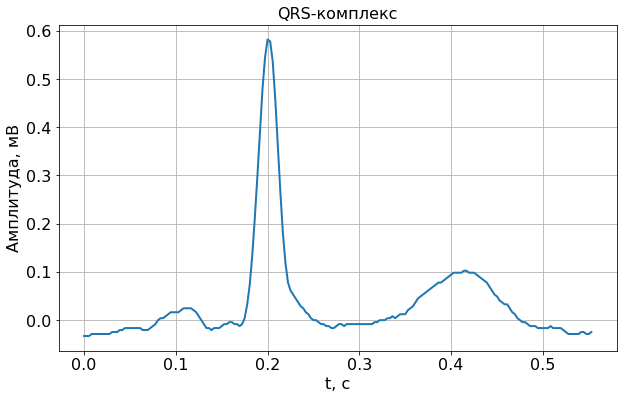

In [146]:
def signal_plot(data: Sequence[Any], Fs: int = 360, title: str = ''):
    '''График сигнала ЭКГ.
    
    Parameters
    ----------
    data : Sequence[Any]
        Отсчеты сигнала.
        
    Fs : int
        Частота дискретизации.
        
    title : str
        Заголовок.
    '''
    t = [i / Fs for i in range(len(data))]

    plt.figure(figsize=(10, 6))
    plt.plot(t, data, linewidth=2)
    plt.title(title, fontsize=16)
    plt.xlabel('t, с', fontsize=16)
    plt.ylabel('Амплитуда, мВ', fontsize=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.grid()


data_i = all_signals[78][2600:2800] - np.median((all_signals[78][2600:2800]))
signal_plot(data_i, Fs=360, title='QRS-комплекс')

Загрузка всех меток и лейблов в один массив

In [147]:
all_marks = []
all_classes = []

for i in range(len(filename_annotation_afdb)): # AFDB
    marks_i, classes_i = create_marks_afdb('C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/afdb/' + filename_annotation_afdb[i],
                                           all_fibr_bounds[i])
    all_marks.append(marks_i)
    all_classes.append(classes_i)

for filename in filename_annotation_mit: # MIT-BIH
    marks_i, classes_i = create_marks('C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/mit_bih/' + filename)
    all_marks.append(marks_i)
    all_classes.append(classes_i)

for filename in filename_annotation_mgh: # MGH/MF
    marks_i, classes_i = create_marks('C:/Users/User/Desktop/ЛЭТИ/4 курс/ДИПЛОМ/mgh_mf/' + filename)
    all_marks.append(marks_i)
    all_classes.append(classes_i)

Проверка равенства длины массивов меток и лейблов

In [148]:
for rec_num in range(len(all_marks)):
    if len(all_marks[rec_num]) > len(all_classes[rec_num]):
        print(f'В записи с индексом {rec_num} меток больше чем лейблов')
    elif len(all_marks[rec_num]) < len(all_classes[rec_num]):
        print(f'В записи с индексом {rec_num} меток меньше чем лейблов')
        
    if rec_num == len(all_marks) - 1:
        print('Все хорошо')

Все хорошо


Распределение классов

In [149]:
for i in range(len(all_classes)):
    if i == 0:
        df_class = pd.Series(all_classes[i])
        classes_distribution = pd.DataFrame({'Class':df_class})
    else:
        df_class = pd.Series(all_classes[i])
        df_i = pd.DataFrame({'Class':df_class})
        classes_distribution = classes_distribution.append(df_i, ignore_index=True)

In [150]:
classes_distribution['Class'].value_counts()

N       410836
AFIB    217885
V        13063
S         7410
/         2820
L         2003
"         1390
A          873
+          785
F          711
c          504
a          385
~          299
z          299
*          236
j          222
x          187
w          123
#           72
Q           63
|           43
e           31
J            4
?            3
E            1
n            1
r            1
f            1
Name: Class, dtype: int64

Имена всех записей для статистики.

In [151]:
all_rec_names = []

for i in range(len(afdb_channels)):
    all_rec_names.append(afdb_channels[i][0])
for i in range(len(mit_channels)):
    all_rec_names.append(mit_channels[i][0])
for i in range(len(mgh_channels)):
    all_rec_names.append(mgh_channels[i][0])

Мы загрузили все сигналы и метки. Теперь требуется сформировать массивы отрезков по 6 сокращений, в которых целевая переменная - 4 по счету сокращение. Выбор такой длины обусловлен тем, что временная связь между сокращеними существует для 3-х до и 2-х после данного сокращения.

## Формирование массивов сокращений

Для исследования выбраны 6 категорий:
- "V": [numrec, [N, N, N, V, N, N],...]
- "A": [numrec, [N, N, N, A/S, N, N],...]
- "AFIB": [numrec, [AFIB, AFIB, AFIB, AFIB, AFIB, AFIB],...]
- "NV": [numrec, [V, V, V, N, V, V],...]
- "NA": [numrec, [A/S, A/S, A/S, N, A/S, A/S],...]
- "N": [numrec, [N, N, N, N, N, N],...]

где numrec - номер записи. Параллельно создаем массив RR-интервалов. RR $(i - 1)$ для $i$-го сокращения. Размерность (M, N), где M - номер записи, N - количество седечных сокращений в записи.

Массив для AFDB.

In [152]:
RR_afdb = []
fs = 250

for record in all_marks[:8]:
    rr_i = []
    rr_i.append((record[33] - record[30]) / (fs * 3)) # Нулевой RR - среднее от трех сокращений
    for i in range(len(record) - 1): 
        if record[i] == 0 and record[i+1] == 0:
            rr_i.append((record[33] - record[30]) / (fs * 3))
            continue
        
        if record[i] == 0 and record[i+1] > 0:
            rr_i.append((record[33] - record[30]) / (fs * 3))
            continue
        
        interval_i = (record[i+1] - record[i]) / fs
        if interval_i < 10 and interval_i >= 0.2:
            rr_i.append(interval_i)
        else:
            rr_i.append(np.median(rr_i)) # Замена, если из-за разрыва в сигнале большое значение
    RR_afdb.append(rr_i)
RR_afdb = np.array(RR_afdb)

Массив для MIT и MGH

In [153]:
RR_mit_mgh = []
fs = 360

for record in all_marks[8:]:
    rr_i = []
    rr_i.append((record[33] - record[30]) / (fs * 3)) # Нулевой RR - среднее от некоторых сокращений
    for i in range(len(record) - 1):
        if record[i] == 0 and record[i+1] == 0:
            rr_i.append((record[33] - record[30]) / (fs * 3))
            continue
        
        if record[i] == 0 and record[i+1] > 0:
            rr_i.append((record[33] - record[30]) / (fs * 3))
            continue
            
        interval_i = (record[i+1] - record[i]) / fs
        if interval_i < 10 and interval_i >= 0.2:
            rr_i.append(interval_i)
        else:
            rr_i.append(np.median(rr_i)) # Замена, если большое или маленькое значение
    RR_mit_mgh.append(rr_i)
RR_mit_mgh = np.array(RR_mit_mgh)

Объединение

In [154]:
all_RR = np.concatenate((RR_afdb, RR_mit_mgh), axis=0)

Теперь нужно "нарезать" QRS-комплексы, чтобы посчитать по ним признаки.

In [155]:
def create_QRS_array(data: Sequence[float], marks: List[float], QRS_len: int, shift: int, rsmpl: bool = False) -> List:
    '''Создание двумерного массива M на N,
    где M - количество сердечных сокращений в окне,
    а N - число отсчетов отрезка сигнала.
    
    Parameters
    ----------
    data : Sequence[float]
        Сигнал целой записи.
    
    marks : List[float]
        Срез координат R-пиков.
        
    QRS_len : int
        Длина сердечногокомплекса в отсчетах.
        
    shift : int
        Сдвиг окна относительно R-пика. (+ - вправо)
        
    rsmpl: bool
        Передискретизация с 250 Гц до 360 Гц при необходимости.

    Returns
    -------
    QRS : List[List[float]]
        Массив отрезков сигнала.
    '''
    QRS = []
    
    for mark in marks:
        QRS_i = []
        
        # Если первое сокращение короче окна
        if mark - QRS_len + shift < 0:
            QRS_i = list(data[0:mark + QRS_len + shift])
            
            if rsmpl == True:
                QRS_i = signal.resample(QRS_i, int(360 / 250 * len(QRS_i)))
            QRS.append(QRS_i)
            continue
            
        QRS_i = list(data[mark - QRS_len + shift:mark + QRS_len + shift])
        
        if rsmpl == True:
            QRS_i = signal.resample(QRS_i, int(360 / 250 * len(QRS_i)))
        QRS.append(QRS_i)
        
    return QRS

Выбор записей для формирования тестового набора данных

In [156]:
test_rec_index = [2, 5, 6, 25, 28, 30, 39, 43, 60, 65, 69, 72, 73, 74, 75, 78, 79, 80]
bad_rec = [] # [15, 16, 19, 23, 25, 26] # Записи, которые содержат AFIB, но я учитываю их как N, не будем их использовать.
             # Будем, потому что это не повлияло на результат.

### 1. Формирование категории "V": [numrec, [N, N, N, V, N, N],...]

In [157]:
V_cat = []
V_cat_rr = []
window_len = 6

for numrec in range(len(all_classes)): # Номер записи
    rec_i = [numrec] # Добавляем номер записи в начало чтобы потом выбирать записи
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1): # Номер сокращения
        slice_i = all_classes[numrec][numqrs: numqrs + window_len] # Срез классов на записи с номером numrec длиной window_len
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['N','N','N','V','N','N']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len] # Срез координат R-пиков
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i, QRS_len=130, shift=35))
            rec_i_rr.append(slice_i_rr)
        #if len(rec_i) > 90 and numrec in test_rec_index: # Ограничение для тестовых записей
         #   break
        if len(rec_i) > 90 and numrec not in test_rec_index: # Ограничение для обучающих записей
            break
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    V_cat.append(rec_i)
    V_cat_rr.append(rec_i_rr)

Статистика по данной категории для проверки отношения трейна к тесту.

In [158]:
def stat(category: List, all_rec_names: List, full: bool = False):
    '''Количество эпизодов данной категории в каждой записи'''
    sum_len_matrix = 0
    test_sum = 0
    for i in range(len(category)):
        sum_len_matrix += len(category[i]) - 1
        if i not in test_rec_index:
            test_sum += len(category[i]) - 1
        
        if full == True:
            print(f'Количество эпизодов в записи номер {i} -- "{all_rec_names[i]}" = {len(category[i]) - 1}')
        
    print(f'\nВсего {sum_len_matrix}\n')
    print(f'Train {test_sum} - {round(test_sum / sum_len_matrix * 100, 2)} %\n')
    print(f'Test {sum_len_matrix - test_sum} - {round((sum_len_matrix - test_sum) / sum_len_matrix * 100, 2)} %')

In [159]:
stat(V_cat, all_rec_names, full=True)

Количество эпизодов в записи номер 0 -- "04048" = 0
Количество эпизодов в записи номер 1 -- "04746" = 0
Количество эпизодов в записи номер 2 -- "04936" = 0
Количество эпизодов в записи номер 3 -- "05121" = 0
Количество эпизодов в записи номер 4 -- "05261" = 0
Количество эпизодов в записи номер 5 -- "06995" = 0
Количество эпизодов в записи номер 6 -- "07879" = 0
Количество эпизодов в записи номер 7 -- "08455" = 0
Количество эпизодов в записи номер 8 -- "100" = 1
Количество эпизодов в записи номер 9 -- "106" = 15
Количество эпизодов в записи номер 10 -- "113" = 0
Количество эпизодов в записи номер 11 -- "114" = 33
Количество эпизодов в записи номер 12 -- "116" = 90
Количество эпизодов в записи номер 13 -- "119" = 76
Количество эпизодов в записи номер 14 -- "200" = 23
Количество эпизодов в записи номер 15 -- "201" = 34
Количество эпизодов в записи номер 16 -- "202" = 18
Количество эпизодов в записи номер 17 -- "205" = 17
Количество эпизодов в записи номер 18 -- "209" = 1
Количество эпизод

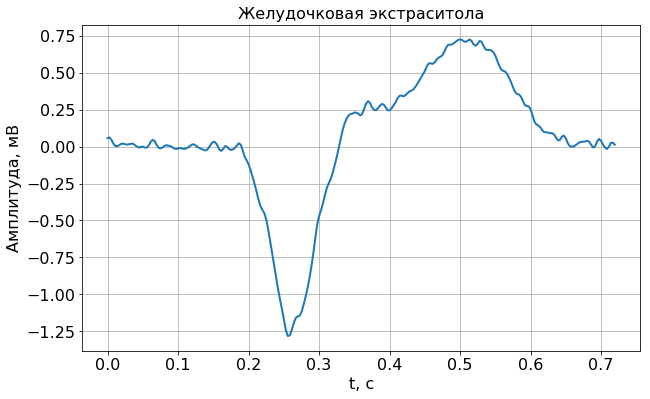

In [160]:
signal_plot(V_cat[87][2][3], Fs=360, title='Желудочковая экстраситола')

### 2. Формирование категории "A": [numrec, [N, N, N, A/S, N, N],...]

In [161]:
A_cat = []
A_cat_rr = []
window_len = 6

for numrec in range(len(all_classes)):
    rec_i = [numrec]
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1):
        slice_i = all_classes[numrec][numqrs: numqrs + window_len]
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['N','N','N','A','N','N'] or slice_i == ['N','N','N','S','N','N']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len]
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i, QRS_len=130, shift=35))
            rec_i_rr.append(slice_i_rr)
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    A_cat.append(rec_i)
    A_cat_rr.append(rec_i_rr)

#### Статистика по данной категории

In [162]:
stat(A_cat, all_rec_names, full=False)


Всего 3267

Train 2247 - 68.78 %

Test 1020 - 31.22 %


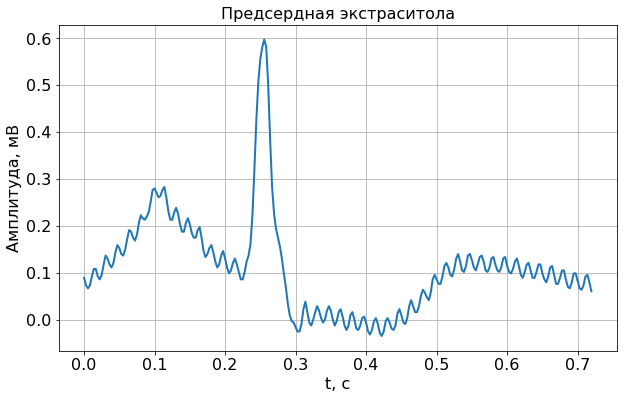

In [163]:
signal_plot(A_cat[73][2][3], Fs=360, title='Предсердная экстраситола')

### 3. Формирование категории "AFIB": [numrec, [AFIB, AFIB, AFIB, AFIB, AFIB, AFIB],...]
Для AFDB необходим RESAMPLE С 250 до 360 Гц

In [164]:
AFIB_cat = []
AFIB_cat_rr = []
window_len = 6
w_width = 90

for numrec in range(len(all_classes[:8])):
    rec_i = [numrec]
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1):
        slice_i = all_classes[numrec][numqrs: numqrs + window_len] # Срез классов на записи с номером numrec длиной window_len
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['AFIB','AFIB','AFIB','AFIB','AFIB','AFIB']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len]
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i,\
                                          QRS_len=int(w_width * 25 / 36), shift=5, rsmpl=True))
            rec_i_rr.append(slice_i_rr)
        if len(rec_i) > 334 and numrec in test_rec_index:
            break
        elif len(rec_i) > 440 and numrec not in test_rec_index:
            break
    
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    AFIB_cat.append(rec_i)
    AFIB_cat_rr.append(rec_i_rr)

Статистика по данной категории

In [165]:
stat(AFIB_cat, all_rec_names, full=True)

Количество эпизодов в записи номер 0 -- "04048" = 440
Количество эпизодов в записи номер 1 -- "04746" = 440
Количество эпизодов в записи номер 2 -- "04936" = 334
Количество эпизодов в записи номер 3 -- "05121" = 440
Количество эпизодов в записи номер 4 -- "05261" = 440
Количество эпизодов в записи номер 5 -- "06995" = 334
Количество эпизодов в записи номер 6 -- "07879" = 334
Количество эпизодов в записи номер 7 -- "08455" = 440

Всего 3202

Train 2200 - 68.71 %

Test 1002 - 31.29 %


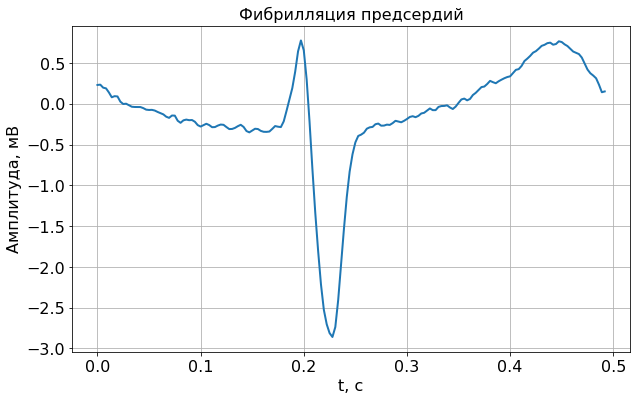

In [166]:
signal_plot(AFIB_cat[7][100][3], Fs=360, title='Фибрилляция предсердий')

### 4. Формирование категории "NV": [numrec, [V, V, V, N, V, V],...]

In [167]:
NV_cat = []
NV_cat_rr = []
window_len = 6

for numrec in range(len(all_classes)):
    rec_i = [numrec]
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1):
        slice_i = all_classes[numrec][numqrs: numqrs + window_len]
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['V','N','N','N','N','N'] or slice_i == ['N','V','N','N','N','N'] or \
            slice_i == ['N','N','V','N','N','N'] or slice_i == ['N','N','N','N','V','N'] or \
            slice_i == ['N','N','N','N','N','V']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len]
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i, QRS_len=130, shift=35))
            rec_i_rr.append(slice_i_rr)
        if len(rec_i) > 55 and numrec in test_rec_index:
            break
        elif len(rec_i) > 16 and numrec not in test_rec_index:
            break
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    NV_cat.append(rec_i)
    NV_cat_rr.append(rec_i_rr)

Статистика по данной категории

In [168]:
stat(NV_cat, all_rec_names, full=False)


Всего 1237

Train 849 - 68.63 %

Test 388 - 31.37 %


### 5. Формирование категории "NA": [numrec, [A/S, A/S, A/S, N, A/S, A/S],...]

In [169]:
NA_cat = []
NA_cat_rr = []
window_len = 6

for numrec in range(len(all_classes)):
    rec_i = [numrec]
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1):
        slice_i = all_classes[numrec][numqrs: numqrs + window_len]
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['A','N','N','N','N','N'] or slice_i == ['N','A','N','N','N','N'] or \
            slice_i == ['N','N','A','N','N','N'] or slice_i == ['N','N','N','N','A','N'] or \
            slice_i == ['N','N','N','N','N','A'] or slice_i == ['S','N','N','N','N','N'] or \
            slice_i == ['N','S','N','N','N','N'] or slice_i == ['N','N','S','N','N','N'] or \
            slice_i == ['N','N','N','N','S','N'] or slice_i == ['N','N','N','N','N','S']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len]
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i, QRS_len=130, shift=35))
            rec_i_rr.append(slice_i_rr)
        if len(rec_i) > 40 and numrec in test_rec_index:
            break
        elif len(rec_i) > 18 and numrec not in test_rec_index:
            break
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    NA_cat.append(rec_i)
    NA_cat_rr.append(rec_i_rr)

Статистика по данной категории

In [170]:
stat(NA_cat, all_rec_names, full=False)


Всего 1218

Train 825 - 67.73 %

Test 393 - 32.27 %


### 6. Формирование категории "N": [numrec, [N, N, N, N, N, N],...]

In [171]:
N_cat = []
N_cat_rr = []
window_len = 6

for numrec in range(len(all_classes)):
    rec_i = [numrec]
    rec_i_rr = [numrec]
    for numqrs in range(len(all_classes[numrec]) - window_len + 1):
        slice_i = all_classes[numrec][numqrs: numqrs + window_len]
        slice_i_rr = all_RR[numrec][numqrs: numqrs + window_len]
        if slice_i == ['N','N','N','N','N','N']:
            slice_marks_i = all_marks[numrec][numqrs: numqrs + window_len]
            rec_i.append(create_QRS_array(all_signals[numrec], slice_marks_i, QRS_len=130, shift=35))
            rec_i_rr.append(slice_i_rr)
        if len(rec_i) > 15 and numrec in test_rec_index:
            break
        elif len(rec_i) > 9 and numrec not in test_rec_index:
            break
    rec_i = np.array(rec_i)
    rec_i_rr = np.array(rec_i_rr)
    N_cat.append(rec_i)
    N_cat_rr.append(rec_i_rr)

Статистика по данной категории

In [172]:
stat(N_cat, all_rec_names, full=False)


Всего 801

Train 576 - 71.91 %

Test 225 - 28.09 %


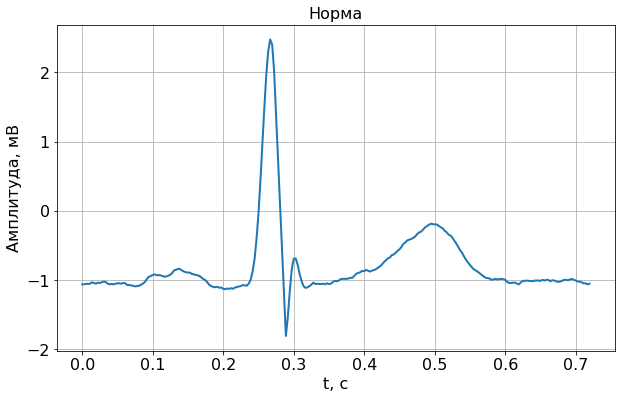

In [173]:
signal_plot(N_cat[12][9][3], Fs=360, title='Норма')

# Расчет признаков
Будут рассчитываться следующие показатели:
- RR-интервал
- Длительность QRS-комплекса
- Коэффициент формы

RR-интервалы были расчитаны в предыдущем пункте.

### Длительность QRS
Для устранения шумов и выделения составляющих будет использован фильтр Баттерворта низкого порядка. Для устранения фазовых искажений применяется фильтрация в две стороны.

In [174]:
def butter_filter_coeff(cutoff: int, fs: int, order: int, btype: str) -> np.ndarray:
    '''Butterworth filter coefficients.
    
    Parameters
    ----------
    cutoff : int
        Filter cutoff frequency.
        
    fs : int
        Sampling frequency.
        
    order : int
        Filter order.
        
    btype : str
        Filter type (low or high).
    
    Returns
    ------
    b, a : np.ndarray
        Filter coefficients.
    '''
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype=btype, analog=False)
    return b, a

def butter_filtration(data: Sequence[float], cutoff: int, fs: int, order: int, btype: str) -> np.ndarray:
    '''
    Filtration data with a butterworth filter.
    
    Parameters
    ----------
    data : Sequence[float]
        Signal.
        
    cutoff : int
        Filter cutoff frequency.
        
    fs : int
        Sampling frequency.
        
    order : int
        Filter order.
        
    btype : str
        Filter type (low or high).
    
    Returns
    -------
    y : np.ndarray
        Filtered data.
    '''
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    y = signal.lfilter(b, a, data)
    return y

In [175]:
def reverse_filt(data: Sequence[float], cutoff: int, fs: int, order: int, btype: str) -> np.ndarray:
    '''Reverse filtration.
    
    Parameters
    ----------
    data : Sequence[float]
        Signal.
        
    cutoff : int
        Filter cutoff frequency.
        
    fs : int
        Sampling frequency.
        
    order : int
        Filter order.
        
    btype : str
        Filter type (low or high).
    
    Returns
    -------
    y : np.ndarray
        Reverse filtered data.
    '''
    reverse_data = data[::-1]
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    y = signal.lfilter(b, a, reverse_data)[::-1]
    
    return y

In [176]:
def filter_response(cutoff: int, fs: int, order: int, btype: str):
    '''
    Butterworth filter frequency response
    
    Parameters
    ----------
    cutoff : int
        Filter cutoff frequency.
        
    fs : int
        Sampling frequency.
        
    order : int
        Filter order.
        
    btype : str
        Filter type (low or high).
    
    Output
    ------
        Frequency response plot.
    '''
    b, a = butter_filter_coeff(cutoff, fs, order, btype)
    w, h = signal.freqz(b, a, worN=8000)
    plt.figure(figsize=(11,3))
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 0.5*fs)
    plt.title(str(btype) + "pass filter frequency response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

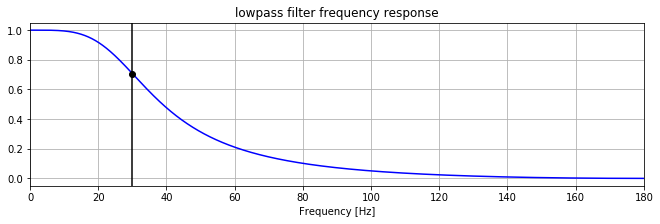

In [177]:
filter_response(cutoff = 30, fs = 360, order = 2, btype = 'low')

In [178]:
def diff(data: Sequence[float]) -> Sequence[float]:
    '''
    Differentiation.
    
    Parameters
    ----------
    data : Sequence[int, float]
        Signal.
    
    Returns
    -------
    diff : Sequence[int, float]
        Differentiated data.
    '''
    diff = []
    
    for i in range(2,len(data)):
            diff.append(data[i]-data[i-2])
    
    # Добавим два нуля в конец
    diff.append(0.0) 
    diff.append(0.0)
    
    return diff

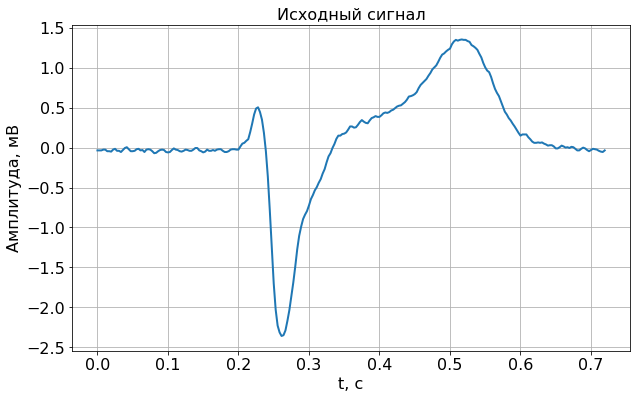

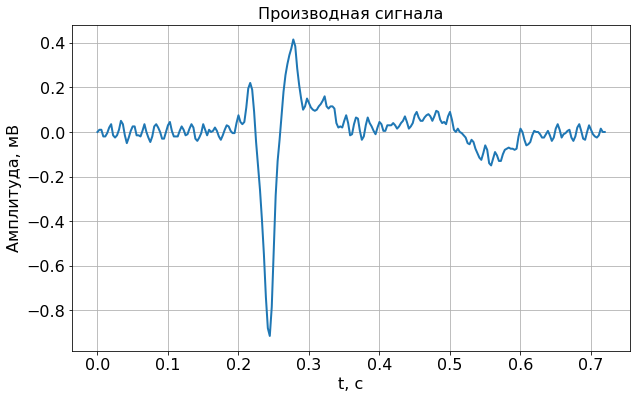

In [179]:
signal_plot(V_cat[11][32][3], Fs=360, title='Исходный сигнал')
signal_plot(diff(V_cat[11][32][3]), Fs=360, title='Производная сигнала')

#### Предобработка сигнала для расчета длительности QRS.
1. Фильтрация в две стороны с помощью ФНЧ и ФВЧ
2. $\begin{aligned}sum = |x(n)|+ \Bigl|\frac{\partial x(n)}{\partial t}\Bigl| * k_1 + \Bigl|\frac{\partial^2 x(n)}{\partial t^2}\Bigl| *k_2 \end{aligned}$.

где x(n) - отсчеты отфильрованного сигнала.
- $k_1, k_2$ - коэффициенты для компенсации падения амплитуды в результате дифференцирования.

In [180]:
def preprocessing(data: Sequence[float], fs: int, lp_cutoff: int, hp_cutoff: int, lp_order: int,
                  hp_order: int, k1: float, k2: float) -> np.ndarray:
    
    '''Приведение сигнала к виду, удобному для расчета длительности QRS.
    
    Parameters
    ----------
    data : Sequence[float]
        Сигнал.
        
    fs : int
        Частота дискретизации.
        
    lp_cutoff : int
        Частота среза ФНЧ.
        
    hp_cutoff : int
        Частота среза ФВЧ.
        
    lp_order : int
        Порядок ФНЧ.
        
    hp_order : int
        Порядок ФВЧ.
        
    k1, k2 : float
        Коэффициенты для компинсации подавления сигнала
        в результате дифференцирования.
        
    btype : str
        Filter type (low or high).
    
    Returns
    -------
    sum_qrs : np.ndarray
        Обработанный сигнал.
    '''
    #ФНЧ в две стороны
    lowpass_filt = butter_filtration(data, fs = fs, cutoff = lp_cutoff, order = lp_order, btype = 'low')
    lowpass_filt = reverse_filt(lowpass_filt, fs = fs, cutoff = lp_cutoff, order = lp_order, btype = 'low')
    
    # ФВЧ в две стороны
    highpass_filt = butter_filtration(lowpass_filt, fs = fs, cutoff = hp_cutoff, order = hp_order, btype = 'high')
    highpass_filt = reverse_filt(highpass_filt, fs = fs, cutoff = hp_cutoff, order = hp_order, btype = 'high')
    
    # Дифференцирование
    diff_I = diff(highpass_filt)
    diff_II = diff(diff_I)
    
    # Сумма модулей сигнала и двух производных
    sum_qrs = np.abs(highpass_filt) + np.abs(diff_I)*k1 + np.abs(diff_II)*k2
    
    return sum_qrs

**Предложено 2 способа расчета длительности QRS-комплекса:**
- Приближение полиномом 2 степени
- Метод на основе площади сигнала и линейной регрессии

In [181]:
def polynom(data: Sequence[float], degree: int = 2) -> np.ndarray:
    '''Интерполяция полином n степени.
    
    Parameters
    ----------
    data : Sequence[float]
        Предобработанный с помощью функции preprocessing сигнал.
        
    degree : int
        Степень полинома.
    
    Returns
    -------
    polinom_y : np.ndarray
        График полинома.
        
    t : np.ndarray
        Аргумент полинома.
        
    polinom.r : np.ndarray
        Корни полинома.
        
    x1, x2 : float
        Границы расчета полинома
    '''
    x1 = int(0.3*len(data))
    x2 = int(0.5*len(data))
    
    k = np.array([i for i in range(x1,x2)])
    
    # Коэффициенты полинома
    z = np.polyfit(k, data[x1:x2], degree)
    
    # Создание экземпляра класса полином
    polinom = np.poly1d(z)
    
    t = np.array([i for i in range(0,len(data))])
    polinom_y = polinom(t)
    
    return polinom_y, t, polinom.r, x1, x2

In [182]:
def interpolate_qrs(QRS_i: Sequence[float], QRS_filt_i: Sequence[float], plot: bool = False) -> float:
    '''Расчет длительности QRS по пересечению полинома с нулем и график.
    
    Parameters
    ----------
    QRS_i : Sequence[float]
        Исходный сигнал.
        
    QRS_filt_i : Sequence[float]
        Предобработанный сигнал.
        
    plot: bool
        Нужен график?
    
    Returns
    -------
    duration : float
        Длительность QRS.
    '''
    poly, t, roots, x1, x2 = polynom(QRS_filt_i)
    root1 = int(roots[::-1][0])
    root2 = int(roots[::-1][1])
    
    duration = (root2 - root1) / 360
    
    if plot == True:
        plt.figure(figsize=(10,6))
        plt.plot(QRS_i, linewidth=1.5, label='signal')
        plt.plot(QRS_filt_i, 'k', linewidth=1.5, label='filt')
        plt.plot(t[root1:root2], poly[root1:root2], '--', linewidth=2, label='polynomial')

        plt.axvline(x1, color='k')
        plt.axvline(x2, color='k')
        plt.scatter(roots, [0,0], color='r', s=40, marker='o')
        plt.text(0, max(QRS_i), 'Duration = '+str(round(duration, 4)), fontsize=14)
        
        plt.grid(True)
        plt.legend()
        plt.setp(plt.gca().get_legend().get_texts(), fontsize='14')
        
    return duration

Проверка

0.15

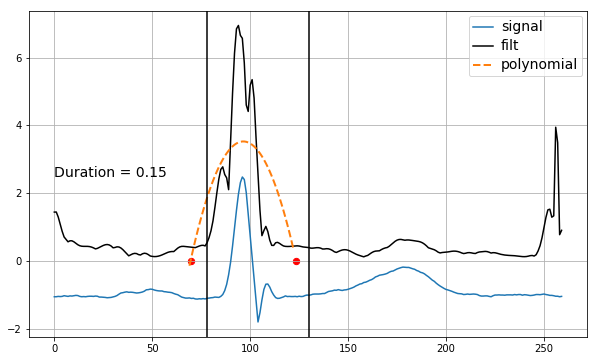

In [183]:
f_QRS = preprocessing(N_cat[12][9][3], fs = 360, lp_cutoff = 25, hp_cutoff = 2,
                        lp_order = 2, hp_order = 2, k1 = 2, k2 = 7)

interpolate_qrs(N_cat[12][9][3], f_QRS, plot = True)

#### Долгая настройка параметров не дала устойчивого результата!
Метод работает плохо, поэтому выбран способ на основе площади сигнала и линейной регрессии.

<code style="background:yellow;color:black">P.S. В предобработку сигнала для данного способа нужно добавить квадратирование!</code>

### Метод на основе линейной регрессии

In [2]:
from sklearn.linear_model import LinearRegression

In [185]:
def qrs_duration(data: Sequence[float], integral_len: int = 120, xreg2: List[float] = [0.2, 0.8],
                 xreg1reg3: List[float] = [0.1, 0.9], shift: int = 35,  plot: bool = False) -> float:
    '''Расчет длительности QRS с помощью линейной регрессии.
    Этапы:
    1. Построение графика кумулятивной суммы преобработанного сигнала
    2. Построение трех линейных регрессий по заданному порогу
    3. Нахождение точек пересечения регрессий и расчет длительности по ним
    
    Parameters
    ----------
    data : Sequence[float]
        Предобработанный сигнал.
        
    integral_len : Sequence[float]
        Длина отрезка сигнала в отсчетах, по которому ведется расчет.
        
    xreg2 : List[float]
        Границы по кумулятивной сумме для расчета центральной регрессии.
        
    xreg1reg3: List[float]
        Границы по кумулятивной сумме для расчета крайних регрессий.
        
    shift : int
        Сдвиг расчетного окна относительно R-пика (изначально  shift = 0). 
    
    plot : bool
        Нужен график?
    
    Returns
    -------
    duration : float
        Длительность QRS.
    '''

    R_coordinate = int(len(data) / 2) - shift
    
    # Границы окна для расчета интеграла
    x1 = R_coordinate - int(integral_len / 2)
    x2 = R_coordinate + int(integral_len / 2)
    integral = []
    cumsum = 0
    
    for i in data[x1: x2]: 
        cumsum += i
        integral.append(cumsum / 40)
    
    # Аргумент "х" для графика кумулятивной суммы
    arg_integr = [i + x1 for i in range(len(integral))]
    
    if len(integral) < 5:
        return 0.0
    
    # 10% и 90% границы
    y_10 = [(integral[-1] - integral[0]) * xreg2[0]] * (x2 - x1) # (x2 - x1) для того, чтобы значение в list
    y_50 = [(integral[-1] - integral[0]) * 0.5] * (x2 - x1) # повторялось (x2 - x1) раз
    y_90 = [(integral[-1] - integral[0]) * xreg2[1]] * (x2 - x1)
    
    # Координаты по "y" для регрессий по краям
    y_reg1 = (integral[-1] - integral[0]) * xreg1reg3[0]
    y_reg3 = (integral[-1] - integral[0]) * xreg1reg3[1]
    x_limit = [i for i in range(x1, x2)]
    
    x_50 = x1 # Х координата 50% площади (идем от х1 пока не достигнем 50% площади)
    for i in integral:
        if i > y_50[0]:
            break
        x_50 += 1
    
    # Левая граница центральной регрессии по проценту от интеграла
    x1_regr2 = 0
    for i in range(len(integral)):
        if integral[i] >= y_10[0]:
            x1_regr2 = x1 + i
            break
    
    # Правая граница центральной регрессии по проценту от интеграла
    x2_regr2 = 0
    for i in range(len(integral)):
        if integral[i] >= y_90[0]:
            x2_regr2 = x1 + i
            break
    
    # Границы по "x" для регрессий по краям
    x_reg1 = 0
    for i in range(len(integral)):
        if integral[i] >= y_reg1:
            x_reg1 = x1 + i
            break
    
    x_reg3 = 0
    for i in range(len(integral)):
        if integral[i] >= y_reg3:
            x_reg3 = x1 + i
            break
    
    # Регрессия в центре
    X_regr2 = np.array([i for i in range(x1_regr2, x2_regr2 + 1)]).reshape((-1, 1))
    y_regr2 = np.array(integral[x1_regr2 - x1: x2_regr2 - x1 + 1])
     
    model2 = LinearRegression()
    model2.fit(X_regr2, y_regr2)
    y_pred_regr2 = model2.predict(np.array(arg_integr).reshape((-1, 1)))
    
    # Регрессия слева
    X_regr1 = np.array([i for i in range(x1, x_reg1 + 1)]).reshape((-1, 1))
    y_regr1 = np.array(integral[0: x_reg1 - x1 + 1])
        
    model1 = LinearRegression()
    model1.fit(X_regr1, y_regr1)
    y_pred_regr1 = model1.predict(np.array(arg_integr).reshape((-1, 1)))
    
    # Регрессия справа
    X_regr3 = np.array([i for i in range(x_reg3, len(integral) + x1)]).reshape((-1, 1))
    y_regr3 = np.array(integral[x_reg3 - x1: ])
    
    model3 = LinearRegression()
    model3.fit(X_regr3, y_regr3)
    y_pred_regr3 = model3.predict(np.array(arg_integr).reshape((-1, 1)))
    
    # Координаты пересечения лин рег
    x1_duration = (model1.intercept_ - model2.intercept_) / (model2.coef_[0] - model1.coef_[0])
    x2_duration = (model3.intercept_ - model2.intercept_) / (model2.coef_[0] - model3.coef_[0])
    y1_duration = model2.predict([[x1_duration]])
    y2_duration = model2.predict([[x2_duration]])
    
    duration = (x2_duration - x1_duration) / 360
    if duration <= 0 or duration >= 0.4:
        return 0.0
    
    if plot == True:

        plt.figure(figsize=(10,6))
        plt.plot(data/5, 'k', linewidth=2, label='Преобразованный сигнал')
        plt.plot(np.array(arg_integr)-3, integral, 'r', linewidth=2.5, label='Интеграл')
        plt.plot(arg_integr, y_pred_regr2, 'orange', linewidth=2.5)
        plt.plot(arg_integr, y_pred_regr1, 'orange', linewidth=2.5, label='Линейная регрессия')
        plt.plot(arg_integr, y_pred_regr3, 'orange', linewidth=2.5)
        
        # Границы интеграла
        plt.axvline(x1, color='k')
        plt.axvline(x2, color='k')
        
        # Горизонтальные границы по интегралу
        plt.plot(x_limit, y_10, 'k', ls ='--', linewidth=1.5)
        plt.plot(x_limit, y_50, 'k', ls ='--', linewidth=1.5)
        plt.plot(x_limit, y_90, 'k', ls ='--', linewidth=1.5)
        
        # Границы QRS
        plt.axvline(x1_duration, color='b', label='Граница QRS').set_linestyle('--') # Левая
        plt.axvline(x2_duration, color='b').set_linestyle('--') # Правая
        
        # Точки пересечения регрессий
        plt.scatter([x1_duration, x2_duration], [y1_duration, y2_duration], color='k', s=70, marker='o')
        
        axes = plt.gca()
        plt.ylim(-1, 2.5)
        plt.xlim(0, 250)
        plt.grid()
        plt.legend()
                 
    return duration

Проверка работоспособности

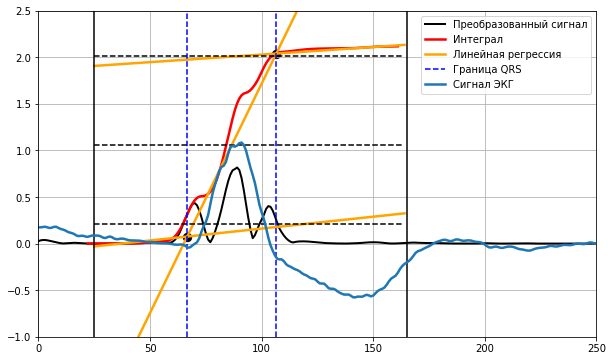

In [222]:
# Патология для примера
QRS = V_cat[30][2][3]

# Ставим на ноль
QRS = QRS - np.median(QRS)

# Предобработка
QRS_filt = preprocessing(QRS, fs = 360, lp_cutoff = 15, hp_cutoff = 5,
                        lp_order = 2, hp_order = 2, k1 = 2, k2 = 40)

# Квадратирование
QRS_filt = QRS_filt**2

# График
qrs_duration(QRS_filt, integral_len = 140, xreg2 = [0.1, 0.95], xreg1reg3 = [0.1, 0.9], shift = 35, plot = True)
plt.plot(QRS, linewidth=2.5, label='Сигнал ЭКГ')
plt.legend()
plt.show()

Далее сформируем массивы длительностей QRS по категориям

In [223]:
def calculate_duration(category: Sequence[Any], shift: int) -> Sequence[Any]:
    '''Расчет длительности QRS по массиву заданной категории.
    
    Pameters
    --------
    category : Sequense[Any]
        Массив сокращений данной категории.
        
    shift: int
        Сдвиг расчетного окна относительно R-пика. (Для AFIB < 15)!
    Returns
    -------
    category_duration : Sequence[Any]
        Массив длительностей.
    '''
    category_duration = []

    for numrec in range(len(category)):
        duration_i = [numrec]
        for num_matrix in range(1, len(category[numrec])):
            matr_i = []
            for QRS in category[numrec][num_matrix]:
                # Вычитание медианы
                QRS = QRS - np.median(QRS)
                
                # Предобработка
                QRS = preprocessing(QRS, fs = 360, lp_cutoff = 15, hp_cutoff = 5,
                            lp_order = 2, hp_order = 2, k1 = 2, k2 = 40)
                
                # Квадратирование
                QRS = QRS ** 2
                matr_i.append(qrs_duration(QRS, integral_len = 160, xreg2 = [0.1, 0.9], xreg1reg3 = [0.1, 0.9], shift = shift))
            duration_i.append(matr_i)
        category_duration.append(duration_i)
        
    return category_duration

In [188]:
V_cat_duration = calculate_duration(V_cat, shift=35)

In [189]:
A_cat_duration = calculate_duration(A_cat, shift=35)

In [226]:
AFIB_cat_duration = calculate_duration(AFIB_cat, shift=0)

In [191]:
NV_cat_duration = calculate_duration(NV_cat, shift=35)

In [192]:
NA_cat_duration = calculate_duration(NA_cat, shift=35)

In [193]:
N_cat_duration = calculate_duration(N_cat, shift=35)

### Коэффициент формы
### $\begin{aligned}FF = \frac{\sigma(f''(x(n)))\cdot\sigma(f(x(n)))}{\sigma(f'(x(n)))^2}\end{aligned}$
- $\sigma$ - СКО
- $x(n)$ - исходный сигнал

In [228]:
def form_factor(data: Sequence[Any], plot: bool = False) -> float:
    '''Коэффициент формы заданного сигнала.
    
    Pameters
    --------
    data : Sequense[Any]
        Массив сигнала.
        
    Returns
    -------
    FF : float
        Коэффициент формы.
    '''
    # Фильтрация
    fs = 360
    lp_cutoff = 30
    hp_cutoff = 2
    lp_order = 2
    hp_order = 2
    
    lowpass_filt = butter_filtration(data, fs=fs, cutoff=lp_cutoff, order=lp_order, btype='low')
    lowpass_filt = reverse_filt(lowpass_filt, fs=fs, cutoff=lp_cutoff, order=lp_order, btype='low')
    highpass_filt = butter_filtration(lowpass_filt, fs=fs, cutoff=hp_cutoff, order = hp_order, btype='high')
    highpass_filt = reverse_filt(highpass_filt, fs=fs, cutoff=hp_cutoff, order = hp_order, btype='high')
    
    #Первая производная
    diff_I = diff(highpass_filt)
    
    #Вторая производная
    diff_II = diff(diff_I)
    
    #Коэффициент формы
    FF = np.std(diff_II[:-35]) * np.std(highpass_filt[:-35]) / (np.std(diff_I[:-35]) * np.std(diff_I[:-35]))
    
    if plot == True:
        plt.figure(figsize=(9,6))
        plt.plot(data, label = 'FF = '+str(round(FF, 2)))
        plt.plot(highpass_filt, 'k', label = 'filt')
        plt.plot(diff_I)
        plt.plot(diff_II,'r')
        plt.grid(True)
        plt.legend()
        
    return FF

**Норма**

1.583038144519635

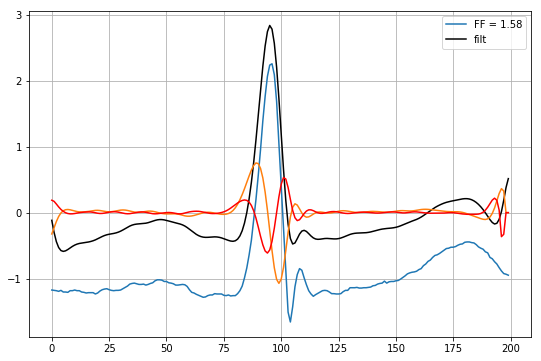

In [229]:
form_factor(V_cat[12][2][2][:200], plot = True)

**Желудочковая экстрасистола**

1.7308258881725593

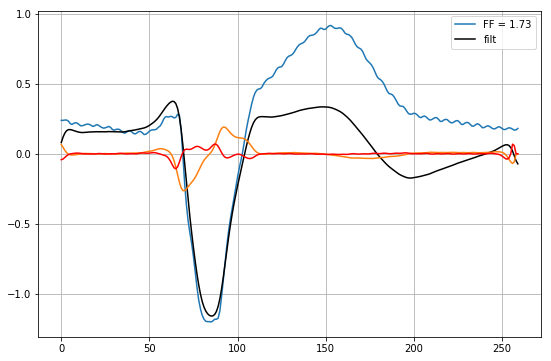

In [230]:
form_factor(V_cat[32][15][3], plot = True)

**Н + ЖЭ**

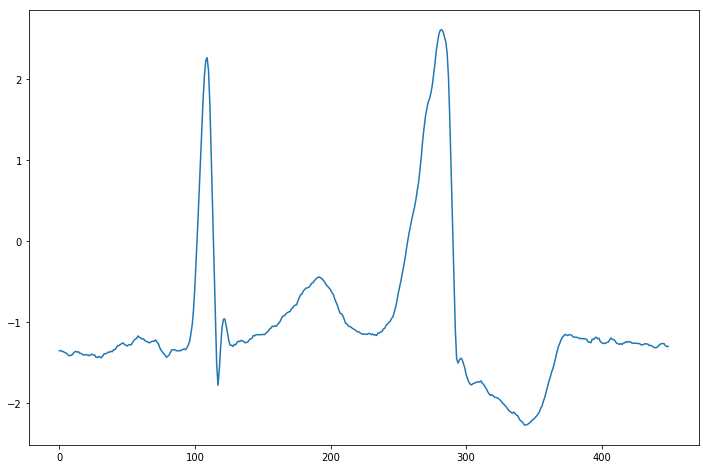

In [231]:
plt.figure(figsize=(12,8))
plt.plot(all_signals[12][34850:35300])
plt.show()

In [232]:
def calculate_ff(category: Sequence[Any]) -> Sequence[Any]:
    '''Расчет коэффициента формы по массиву заданной категории.
    
    Pameters
    --------
    category : Sequense[Any]
        Массив сокращений данной категории.
        
    Returns
    -------
    category_ff : Sequence[Any]
        Массив коэффициентов формы.
    '''
    category_ff = []
    
    for numrec in range(len(category)):
        ff_i = [numrec]
        for num_matrix in range(1, len(category[numrec])):
            matr_i = []
            for QRS in category[numrec][num_matrix]:
                matr_i.append(form_factor(QRS))

            ff_i.append(matr_i)
        category_ff.append(ff_i)
        
    return category_ff

In [233]:
V_cat_ff = calculate_ff(V_cat)

In [234]:
A_cat_ff = calculate_ff(A_cat)

In [235]:
AFIB_cat_ff = calculate_ff(AFIB_cat)

In [236]:
NV_cat_ff = calculate_ff(NV_cat)

In [237]:
NA_cat_ff = calculate_ff(NA_cat)

In [238]:
N_cat_ff = calculate_ff(N_cat)

Все признаки рассчитаны. Требуется собрать все воедино и сформировать наборы данных.

## Формирование датасета

### Для полносвязной сети
#### Train/Validation

In [239]:
def concat_features(X: List, y: List, target_name: str, train: bool, *feature_sets: List[Any]) -> List:
    '''Конкатенация признаков и дополнение ими массива.
    
    Pameters
    --------
    X : List
        Массив признаков для дополнения.
        
    y : List
        Массив целевой переменной для дополнения.
    
    target_name : str
        Обозначение вида патологии.
        
    train : bool
        Выбор режима формирования: для трейна или для теста.
        True - отбор записей из all_rec_names не считая test_rec_index.
        False - отбор из test_rec_index.
        
    feature_sets : List[Any]
        Массивы признаков для данного вида патологии.
        
    Returns
    -------
    X - дополненный массив признаков.
    y - дополненный массив целевой переменной.
    '''
    for numrec in range(len(feature_sets[0])):
        if train:
            # test_rec_index и bad_rec заданы при отборе записей
            if numrec not in test_rec_index and numrec not in bad_rec:
                for m_ind in range(1, len(feature_sets[0][numrec])):

                    list_of_feature = []

                    # Конкатенация признаков
                    for feature in feature_sets:
                        list_of_feature += feature[numrec][m_ind]

                    X.append(list_of_feature)
                    y.append(target_name)
                    
        else:
            if numrec in test_rec_index and numrec not in bad_rec:
                for m_ind in range(1, len(feature_sets[0][numrec])):
                    list_of_feature = []
                    
                    for feature in feature_sets:
                        list_of_feature += feature[numrec][m_ind]
                    X.append(list_of_feature)
                    y.append(target_name)
                
    return X, y

In [240]:
X = []
y = []

X, y = concat_features(X, y, 'V', True, V_cat_duration, V_cat_ff, V_cat_rr)
X, y = concat_features(X, y, 'A', True, A_cat_duration, A_cat_ff, A_cat_rr)
X, y = concat_features(X, y, 'AFIB', True, AFIB_cat_duration, AFIB_cat_ff, AFIB_cat_rr)
X, y = concat_features(X, y, 'N', True, NV_cat_duration, NV_cat_ff, NV_cat_rr)
X, y = concat_features(X, y, 'N', True, NA_cat_duration, NA_cat_ff, NA_cat_rr)
X, y = concat_features(X, y, 'N', True, N_cat_duration, N_cat_ff, N_cat_rr)

In [241]:
print(list(map(lambda x: round(x, 2), X[0])), [y[0]])
print(list(map(lambda x: round(x, 2), X[1])), [y[1]])

[0.05, 0.06, 0.06, 0.08, 0.05, 0.06, 1.41, 1.39, 1.4, 1.57, 1.42, 1.42, 0.78, 0.79, 0.81, 0.54, 1.13, 0.79] ['V']
[0.06, 0.06, 0.06, 0.08, 0.06, 0.06, 1.52, 1.5, 1.51, 1.68, 1.53, 1.52, 0.9, 0.94, 0.93, 0.53, 1.19, 0.91] ['V']


In [242]:
print(len(X))
print(len(y))

8979
8979


#### Test

In [243]:
X_test = []
y_test = []

X_test, y_test = concat_features(X_test, y_test, 'V', False, V_cat_duration, V_cat_ff, V_cat_rr)
X_test, y_test = concat_features(X_test, y_test, 'A', False, A_cat_duration, A_cat_ff, A_cat_rr)
X_test, y_test = concat_features(X_test, y_test, 'AFIB', False, AFIB_cat_duration, AFIB_cat_ff, AFIB_cat_rr)
X_test, y_test = concat_features(X_test, y_test, 'N', False, NV_cat_duration, NV_cat_ff, NV_cat_rr)
X_test, y_test = concat_features(X_test, y_test, 'N', False, NA_cat_duration, NA_cat_ff, NA_cat_rr)
X_test, y_test = concat_features(X_test, y_test, 'N', False, N_cat_duration, N_cat_ff, N_cat_rr)

In [244]:
print(len(X_test))
print(len(y_test))

4027
4027


### Для сверточной сети
**Формирование матриц признаков**

Матрица признаков определяется для набора сокращений, в котором для каждого из них поставлено в соответствие значение определенного признака. Матрица представляет собой двумерный тензор, где каждый элемент $a_{ij}$ получен путем деления признака $i$-го сокращения на признак $j$-го сокращения:

<center>$\begin{aligned}a_{ij}=\frac{x_i}{x_j}\end{aligned}$</center>


Для коэф. формы отношения переводятся в угловую меру: $\begin{aligned}\alpha = \frac{\pi}{4} - \Bigl|arctg\Bigl(\frac{x1}{x2}\Bigl) - \frac{\pi}{4}\Bigl|\end{aligned}$

Это позволяет получить свойство коммуникативности для операции отношения и нормировать его (в последствии позволяет получить симметричную матрицу).

In [245]:
def features_angle(x1: float, x2: float) -> float:
    '''
    Угловая мера двух признаков в пространстве двух признаков.
    Чем больше различия между значениями тем ближе к 0.
    
    Parameters
    ----------
    x1, x2 : float
        Значения признаков.
    
    Returns
    -------
    Угол в радианах, нормированный на pi/4: 1 >= alpha > 0
    '''
    if x2 == 0:
        return 0.0
    
    return (np.pi / 4 - np.abs(math.atan(x1 / x2) - np.pi/4))/np.pi*4

Чем больше различия между значениями признака, тем ближе значение к 0. Одинаковые значения дадут 1.

In [246]:
x1, x2 = 1.4, 1.9
x3, x4 = 2, 2
x5, x6 = 3, 0

print(features_angle(x1, x2))
print(features_angle(x3, x4))
print(features_angle(x5, x6))

0.8085411514630197
1.0
0.0


In [247]:
def create_matrix(data: Sequence, norm: bool = False) -> List:
    '''
    Матрица признаков для заданной последовательности признаков.
    
    Parameters
    ----------
    data : Sequence
        Массив значений признаков.
    
    Returns
    -------
    matrix : List
        Матрица признаков.
    '''
    matrix = []
    
    if norm == True:
        for j in range(len(data)):
            row = []
            for k in range(len(data)):
                row.append(features_angle(data[j],data[k]))

            matrix.append(row)
            
    else:
        for j in range(len(data)):
            row = []
            for k in range(len(data)):
                try:
                    ratio = float(data[j])/float(data[k])
                except ZeroDivisionError:
                    ratio = 0.0
                row.append(ratio)  

            matrix.append(row)
        
    return matrix

#### Train/Validation

In [248]:
def concat_feature_matrices(X: List, y: List, target_name: str, train: bool,
                            norm_index: List, *feature_sets: List) -> List:
    '''Формирование матриц признаков и объединение их в тензор 3 порядка.
    Дополнение ими массива матриц.
    
    Pameters
    --------
    X : List
        Массив матриц признаков для дополнения.
        
    y : List
        Массив целевой переменной для дополнения.
    
    target_name : str
        Обозначение вида патологии.
        
    train : bool
        Выбор режима формирования: для трейна или для теста.
        True - отбор записей из all_rec_names не считая test_rec_index.
        False - отбор из test_rec_index.
        
    norm_index: List
        Список порядковых номеров признаков, которые требуется нормировать.
        
    feature_sets : List
        Массивы признаков для данного вида патологии.
        
    Returns
    -------
    X - дополненный массив матриц признаков.
    y - дополненный массив целевой переменной.
    '''
    for numrec in range(len(feature_sets[0])):
        if train:
            # test_rec_index и bad_rec заданы при отборе записей
            if numrec not in test_rec_index and numrec not in bad_rec:
                for m_ind in range(1, len(feature_sets[0][numrec])):

                    tensor = []

                    # Объединение матриц в тензор 3 порядка
                    for idx in range(len(feature_sets)):
                        if idx in norm_index:
                            tensor.append(create_matrix(feature_sets[idx][numrec][m_ind], norm=True))
                        else:
                            tensor.append(create_matrix(feature_sets[idx][numrec][m_ind], norm=False))

                    X.append(tensor)
                    y.append(target_name)
                    
        else:
            if numrec in test_rec_index and numrec not in bad_rec:
                for m_ind in range(1, len(feature_sets[0][numrec])):
                    
                    tensor = []
                    
                    for idx in range(len(feature_sets)):
                        if idx in norm_index:
                            tensor.append(create_matrix(feature_sets[idx][numrec][m_ind], norm=True))
                        else:
                            tensor.append(create_matrix(feature_sets[idx][numrec][m_ind], norm=False))

                    X.append(tensor)
                    y.append(target_name)
                
    return X, y

In [249]:
X_mtrx = []
y_mtrx = []

X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'V', True, [1], V_cat_duration, V_cat_ff, V_cat_rr)
X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'A', True, [1], A_cat_duration, A_cat_ff, A_cat_rr)
X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'AFIB', True, [1], AFIB_cat_duration, AFIB_cat_ff, AFIB_cat_rr)
X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'N', True, [1], NV_cat_duration, NV_cat_ff, NV_cat_rr)
X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'N', True, [1], NA_cat_duration, NA_cat_ff, NA_cat_rr)
X_mtrx, y_mtrx = concat_feature_matrices(X_mtrx, y_mtrx, 'N', True, [1], N_cat_duration, N_cat_ff, N_cat_rr)

In [250]:
print(f'Размерность тензора: {np.array(X_mtrx[0]).shape}')

Размерность тензора: (3, 6, 6)


In [251]:
print(f'Матрциа признаков:\n\n{np.matrix(X_mtrx[0][1]).round(3)}')

Матрциа признаков:

[[1.    0.989 0.994 0.932 0.993 0.997]
 [0.989 1.    0.995 0.921 0.982 0.986]
 [0.994 0.995 1.    0.926 0.987 0.991]
 [0.932 0.921 0.926 1.    0.938 0.935]
 [0.993 0.982 0.987 0.938 1.    0.996]
 [0.997 0.986 0.991 0.935 0.996 1.   ]]


#### Test

In [252]:
X_test_mtrx = []
y_test_mtrx = []

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'V', False, [1],
                                                   V_cat_duration, V_cat_ff, V_cat_rr)

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'A', False, [1],
                                                   A_cat_duration, A_cat_ff, A_cat_rr)

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'AFIB', False, [1],
                                                   AFIB_cat_duration, AFIB_cat_ff, AFIB_cat_rr)

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'N', False, [1],
                                                   NV_cat_duration, NV_cat_ff, NV_cat_rr)

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'N', False, [1],
                                                   NA_cat_duration, NA_cat_ff, NA_cat_rr)

X_test_mtrx, y_test_mtrx = concat_feature_matrices(X_test_mtrx, y_test_mtrx, 'N', False, [1],
                                                   N_cat_duration, N_cat_ff, N_cat_rr)

In [253]:
print(len(X_test_mtrx))
print(len(y_test_mtrx))

4027
4027


### Экспериментальный датасет для полносвязной сети
Разворачиваем матрицы в строку (берем только числа под главной диагональю). Для 3 матриц признаков получается 45 чисел (признаков).

#### Train/Validation

In [254]:
def matrix_to_raw(X_matrix: List, y_matrix: List) -> List:
    '''Разворачивание матрицы.
    
    Parameters
    ----------
    X_matrix : List
        Массив матриц признаков.
        
    y_matrix: List
        Массив целевой переменной.
        
    Returns
    -------
    X - Массив признаков.
    y - Массив целевой переменной.
    '''
    X = []
    y = []

    for i in range(len(X_matrix)):
        X_i = []
        for j in range(1, len(X_matrix[i][0])):
            X_i += list(X_matrix[i][0][j][0:j])
        for j in range(1, len(X_matrix[i][1])):
            X_i += list(X_matrix[i][1][j][0:j])
        for j in range(1, len(X_matrix[i][2])):
            X_i += list(X_matrix[i][2][j][0:j])

        X.append(X_i)
        y.append(y_matrix[i])
        
    return X, y

In [255]:
X_experiment, y_experiment = matrix_to_raw(X_mtrx, y_mtrx)

In [256]:
print(len(X_experiment))
print(len(y_experiment))

8979
8979


#### Test

In [257]:
X_experiment_test, y_experiment_test = matrix_to_raw(X_test_mtrx, y_test_mtrx)

In [258]:
print(len(X_experiment_test))
print(len(y_experiment_test))

4027
4027


**В итоге имеем 3 набора данных.**

Для полносвязной сети:
1. X, y, X_test, y_test - 18 признаков
2. X_experiment, y_experiment, X_experiment_test, y_experiment_test - 45 признаков

Для сверточной сети:
3. X_mtrx, y_mtrx, X_test_mtrx, y_test_mtrx - изображения с 3 каналами

**Сохранение датасета**

In [2]:
def save_dataset(X: Sequence[float], y: Sequence[str], X_test: Sequence[float] = [],
                 y_test: Sequence[str] = [], name_suffix: str = 'xxx'):
    
    '''Сохранение датасета в файл *.hdf5. 
    Строковые переменные сохраняются в бинарном формате.'''
    
    # Создание директории для датасета
    dirName = 'datasets/'
    if not os.path.exists(dirName):
        os.mkdir(dirName)
    
    # Сохранение
    with h5py.File(dirName + name_suffix + '_X.hdf5', 'w') as f:
        f.create_dataset('default', data=np.asarray(X))
        
    with h5py.File(dirName + name_suffix + '_y.hdf5', 'w') as f:
        f.create_dataset('default', data=np.asarray(y, dtype='S'))
        
    if len(X_test) > 0:
        with h5py.File(dirName + name_suffix + '_X_test.hdf5', 'w') as f:
            f.create_dataset('default', data=np.asarray(X_test))
            
    if len(y_test) > 0:
        with h5py.File(dirName + name_suffix + '_y_test.hdf5', 'w') as f:
            f.create_dataset('default', data=np.asarray(y_test, dtype='S'))

In [260]:
save_dataset(X, y, X_test, y_test, name_suffix='fc18')

save_dataset(X_experiment, y_experiment, X_experiment_test, y_experiment_test, name_suffix='fc45')

save_dataset(X_mtrx, y_mtrx, X_test_mtrx, y_test_mtrx, name_suffix='mtrx')

**Загрузка датасета**

In [2]:
def load_hdf5(path: str, dtype: str) -> np.ndarray:
    '''Загрузка датасета формата *.hdf5.
    
    Parameters
    ----------
    path : str
        Путь с именем файла.
    
    dtype : str
        Тип хранимых данных.
        
    Returns
    -------
    data : np.ndarray
        Датасет.
    '''
    
    if dtype == 'str':
        with h5py.File(path, 'r') as f:
            data = f['default'][:]
            data = data.astype('str')
    else:
        with h5py.File(path, 'r') as f:
            data = f['default'][:]
            
    return data

In [3]:
# 18 признаков
X = load_hdf5('datasets/fc18_X.hdf5', dtype='float')
y = load_hdf5('datasets/fc18_y.hdf5', dtype='str')
X_test = load_hdf5('datasets/fc18_X_test.hdf5', dtype='float')
y_test = load_hdf5('datasets/fc18_y_test.hdf5', dtype='str')

# 45 признаков
X_experiment = load_hdf5('datasets/fc45_X.hdf5', dtype='float')
y_experiment = load_hdf5('datasets/fc45_y.hdf5', dtype='str')
X_experiment_test = load_hdf5('datasets/fc45_X_test.hdf5', dtype='float')
y_experiment_test = load_hdf5('datasets/fc45_y_test.hdf5', dtype='str')

# Матрицы признаков
X_mtrx = load_hdf5('datasets/mtrx_X.hdf5', dtype='float')
y_mtrx = load_hdf5('datasets/mtrx_y.hdf5', dtype='str')
X_test_mtrx = load_hdf5('datasets/mtrx_X_test.hdf5', dtype='float')
y_test_mtrx = load_hdf5('datasets/mtrx_y_test.hdf5', dtype='str')

### Формирование графического представления
Суть метода состоит в формировании графических образов из последовательности сердечных сокращений и последующем анализе этих образов.

Поскольку разные характерные ситуации в сигнале ЭКГ должны давать более или менее устойчивые картины, то при визуальной оценке матриц признаков по категориям должны быть видны отличия у разных видов патологий.

In [11]:
def show_tensor(data: np.ndarray, marks: List = ['N','PAT']):
    '''Построение изображений матриц признаков из тензора.
    
    Parameters
    ----------
    data : np.ndarray
        Тензор признаков.
    
    marks : List
        Список обозначений классов сердечных сокращений:
        [окружение, целевое значение]
    '''
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    ticks = [''] + [marks[0]]*3 + [marks[1]] + [marks[0]]*2

    axes[0].set(title='Duration')
    axes[1].set(title='FF')
    axes[2].set(title='RR')

    im1 = axes[0].imshow(data[0])
    im2 = axes[1].imshow(data[1])
    im3 = axes[2].imshow(data[2])
    
    cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)
    cbar3 = fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

    for ax in axes:
        ax.set_xticklabels(ticks)
        ax.set_yticklabels(ticks)

    fig.tight_layout()
    plt.show()

Усредним матрицы по виду патологии. Возмем по 100 матриц каждой категории.

In [12]:
A_cat_mean = np.zeros((3, 6, 6))
AFIB_cat_mean = np.zeros((3, 6, 6))
V_cat_mean = np.zeros((3, 6, 6))
N_cat_mean = np.zeros((3, 6, 6))

A_cat_counter = 0
AFIB_cat_counter = 0
V_cat_counter = 0
N_cat_counter = 0

N_TENSOR = 100

for i, target_name in enumerate(y_mtrx):
    if target_name == 'A' and A_cat_counter < N_TENSOR:
        A_cat_mean += X_mtrx[i]
        A_cat_counter += 1
    if target_name == 'AFIB' and AFIB_cat_counter < N_TENSOR:
        AFIB_cat_mean += X_mtrx[i]
        AFIB_cat_counter += 1
    if target_name == 'V' and V_cat_counter < N_TENSOR:
        V_cat_mean += X_mtrx[i]
        V_cat_counter += 1
    if target_name == 'N' and N_cat_counter < N_TENSOR:
        N_cat_mean += X_mtrx[i]
        N_cat_counter += 1
        
A_cat_mean /= A_cat_counter
AFIB_cat_mean /= AFIB_cat_counter
V_cat_mean /= V_cat_counter
N_cat_mean /= N_cat_counter

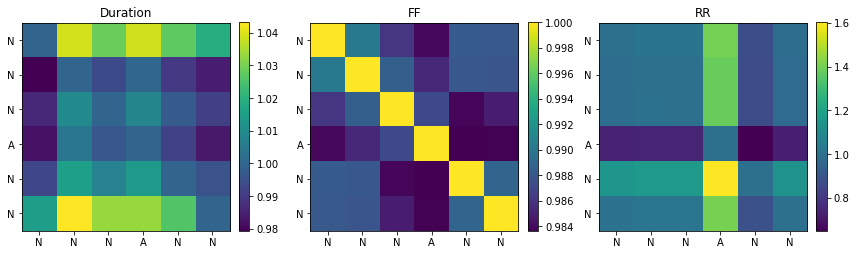

In [13]:
show_tensor(A_cat_mean, marks=['N', 'A'])

Получена устойчивая картина для матрицы RR-интервалов. Она согласуется с наличием компенсаторной паузы у ПЭ. Другие матрицы не дали какого-то характерного изображения. Это происходит из-за того, что форма ПЭ не отличается от формы нормального сокращения.

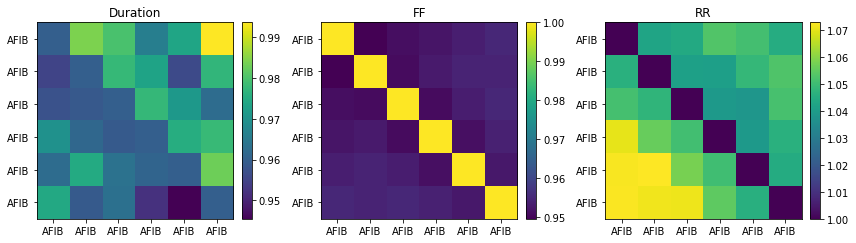

In [14]:
show_tensor(AFIB_cat_mean, marks=['AFIB', 'AFIB'])

Видно, что элементы усредненной матрицы длительности QRS близки к единице. Это согласуется с физиологией ФП. Матрица коэффициентов формы напротив имеет нестандартный вид. Это объясняется наличием f-волн в сигнале ЭКГ, которые могут проявляться во втором отведении. При этом, форма сокращений при ФП не отличается от нормы. Значения элементов усредненной матрицы отношений RR-интервалов также согласуются с физиологией. Значения RR-интервалов при ФП принимают случайные значения. Но, при усреднении, значения результирующей матрицы начинают стремиться к некоторому общему среднему, что видно из полученной матрицы.

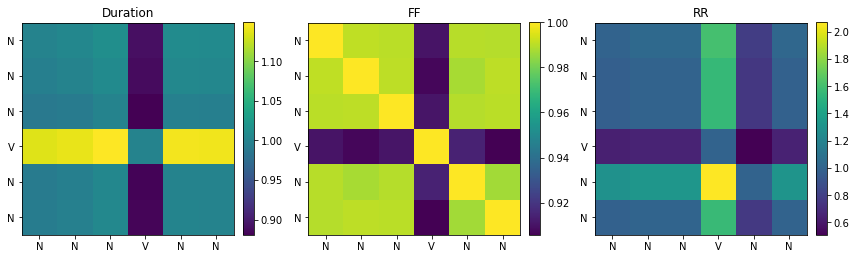

In [15]:
show_tensor(V_cat_mean, marks=['N', 'V'])

Получены устойчивые картины для всех трех признаков. Это согласуется с физиологической особенностью ЖЭ. Широкий QRS-комплекс ЖЭ оставляет явный след на матрице длительности QRS-комплекса. Также, измененная форма ЖЭ дает отличный от нормы коэффициент формы. Изменения RR-интервалов видны не только для ЖЭ, но и для следующего нормального сокращения, поскольку ЖЭ имеет укороченный интервал перед и компенсаторную паузу после.

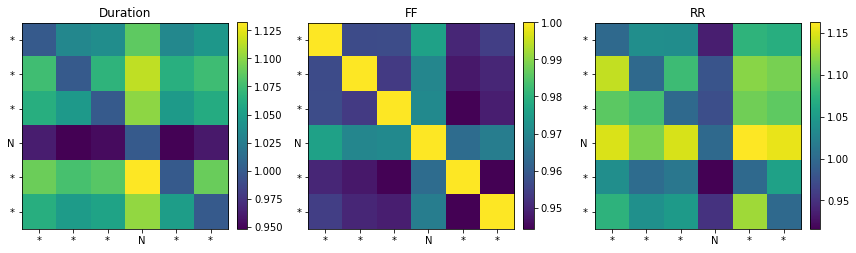

In [16]:
show_tensor(N_cat_mean, marks=['*', 'N'])

Видно, что элементы усредненных матриц дают значения близкие к единице. Это согласуется с тем, что нормальный ритм характеризуется стабильностью физиологических показателей. Самый большой размах значений наблюдается в матрице отношений RR-интервалов. Это может быть следствием наличия дыхательной синусовой аритмии.

## Исследование информативности матриц признаков
Для того чтобы ответить на вопрос является ли признак информативным, требуется оценить отличие значений этого признака при разных патологиях. Если средние значения признака для двух видов сокращений не равны, то признак является информативным, то есть способным «отделить» один вид сокращений от другого.

### Плотности распределения значений под главной диагональю

In [17]:
def avg_under_diag(matrix: np.ndarray) -> float:
    '''Среднее значение элементов матрицы под главной диагональю.
    
    Parameters
    ----------
    matrix : np.ndarray
        Матрица.
        
    Returns
    -------
    float : среднее элементов под диагональю. 
    '''
    under_diag = []
    
    for row_idx in range(1, matrix.shape[0]):
        for column_idx in range(row_idx):
            under_diag.append(matrix[row_idx, column_idx])
            
    return np.sum(under_diag) / len(under_diag)

In [18]:
duration_true = []
ff_true = []
rr_true = []

for i in range(len(X_mtrx)):
    duration_true.append(avg_under_diag(X_mtrx[i][0]))
    ff_true.append(avg_under_diag(X_mtrx[i][1]))
    rr_true.append(avg_under_diag(X_mtrx[i][2]))
    
df_features = pd.DataFrame({'duration': duration_true, 'ff': ff_true, 'rr': rr_true, 'class': y})

df_features.head()

,duration,ff,rr,class
0,1.077564,0.970786,1.108046,V
1,1.057066,0.975100,1.090042,V
2,1.006525,0.960423,1.139535,V
3,1.065248,0.951890,1.079305,V
4,1.027868,0.958283,1.023912,V


In [19]:
duration = []
ff = []
rr = []

for i in range(len(X_mtrx)):
    duration.append((np.mean(X_mtrx[i][0][3][:3])+np.mean(X_mtrx[i][0][3][4:]))/2)
    ff.append(np.mean((X_mtrx[i][1][3][:3])+np.mean(X_mtrx[i][1][3][4:]))/2)
    rr.append(np.mean((X_mtrx[i][2][3][:3])+np.mean(X_mtrx[i][2][3][4:]))/2)
    
df_fc = pd.DataFrame({'duration': duration, 'ff': ff, 'rr': rr, 'class': y})

In [20]:
def density_plot(data: tuple, title: str, x_label: str):
    '''График плотностей распределения.
    
    Parameters
    ----------
    data : tuple
        Кортеж с массивами данных.
        
    title : str
        Заголовок.
        
    x_label : str
        Название оси х.
    '''

    plt.figure(figsize=(15,8))

    sns.kdeplot(data[0], shade=True, color='k', label='ЖЭ', alpha=0.7)
    sns.kdeplot(data[1], shade=True, color='deeppink', label='ПЭ', alpha=0.7)
    sns.kdeplot(data[2], shade=True, color='orange', label='ФП', alpha=0.7)
    sns.kdeplot(data[3], shade=True, color='dodgerblue', label='Норма', alpha=0.7)
    
    plt.title(title, fontsize=16)
    plt.legend()
    plt.setp(plt.gca().get_legend().get_texts(), fontsize='16')
    plt.xlabel('Среднее матрицы длительностей QRS-комплексов', fontsize=18)
    plt.ylabel('Плотность', fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    sns.set_context(rc={'lines.linewidth': 2.5})
    

### Плотность распределения для длительности QRS

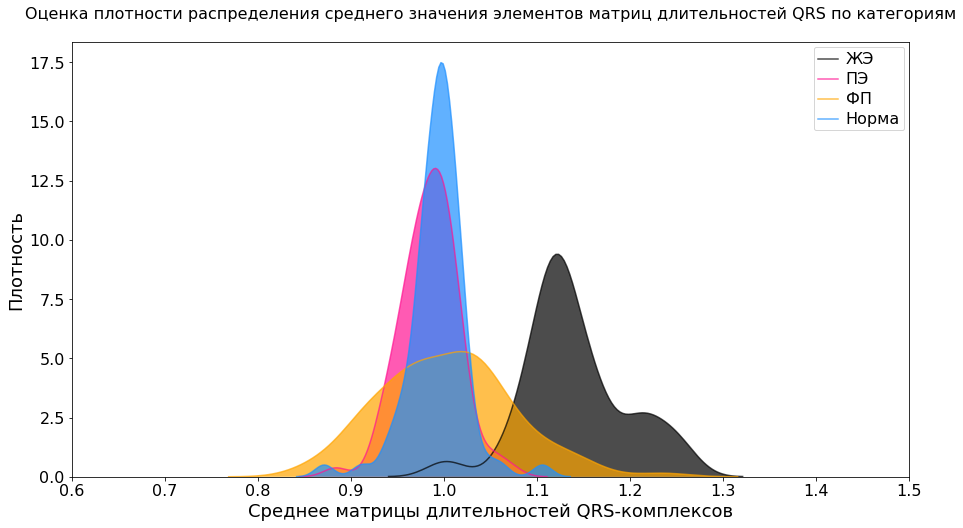

In [21]:
title_QRS = 'Оценка плотности распределения среднего значения элементов матриц длительностей QRS по категориям\n'
x_label_QRS = 'Среднее матрицы длительностей QRS-комплексов'
V_duration = df_fc[df_fc['class'] == 'V']['duration'][100:130]
A_duration = df_fc[df_fc['class'] == 'A']['duration'][820:900]
AFIB_duration = df_fc[df_fc['class'] == 'AFIB']['duration'][2000:2100]
N_duration = df_fc[df_fc['class'] == 'N']['duration'][1100:1180]

density_plot((V_duration, A_duration, AFIB_duration, N_duration), title_QRS, x_label_QRS)
plt.xlim(0.6,1.5)
plt.show()

### Плотность распределения для коэффициента формы

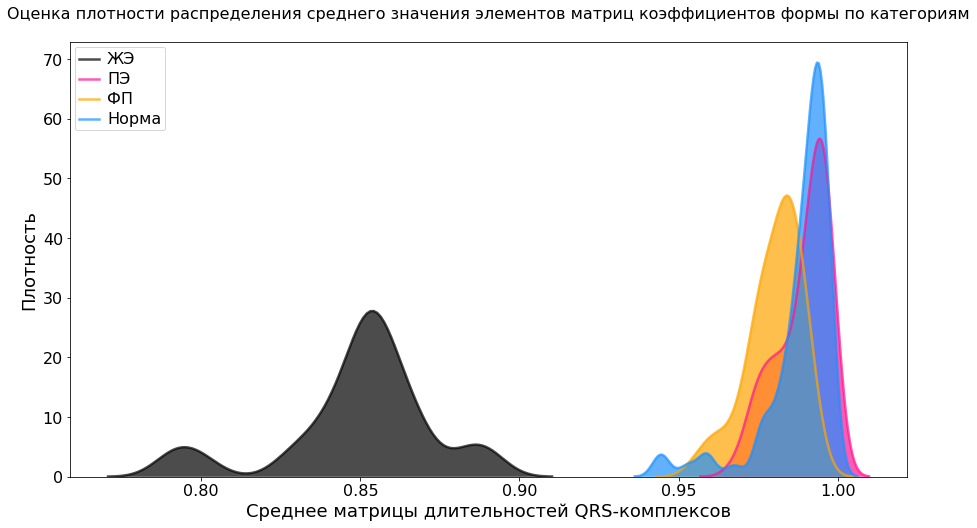

In [22]:
title_ff = 'Оценка плотности распределения среднего значения элементов матриц коэффициентов формы по категориям\n'
x_label_ff = 'Среднее матрицы коэффициентов формы'
V_ff = df_fc[df_fc['class'] == 'V']['ff'][100:130]
A_ff = df_fc[df_fc['class'] == 'A']['ff'][820:900]
AFIB_ff = df_fc[df_fc['class'] == 'AFIB']['ff'][2100:2200]
N_ff = df_fc[df_fc['class'] == 'N']['ff'][1100:1180]

density_plot((V_ff, A_ff, AFIB_ff, N_ff), title_ff, x_label_ff)

### Плотность распределения для длительности RR-интервала

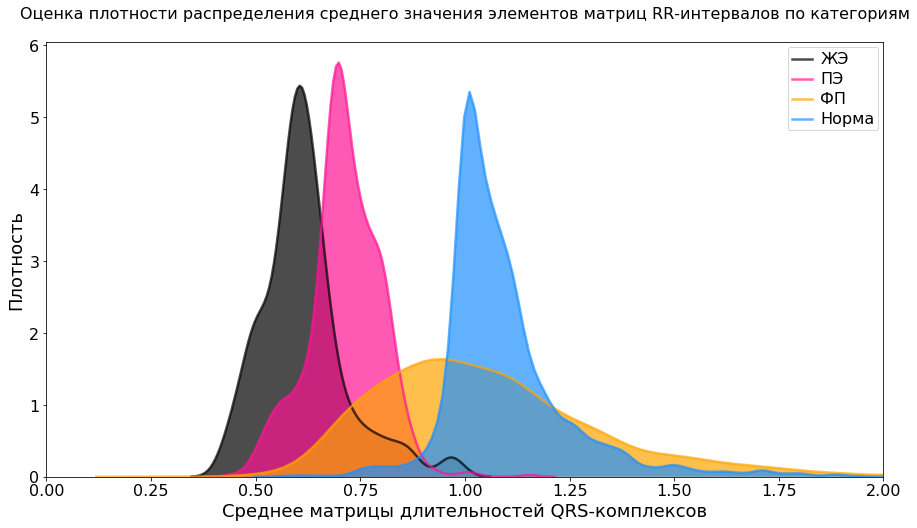

In [23]:
title_rr = 'Оценка плотности распределения среднего значения элементов матриц RR-интервалов по категориям\n'
x_label_rr = 'Среднее матрицы RR-интервалов'
V_rr = df_fc[df_fc['class'] == 'V']['rr'][:100]
A_rr = df_fc[df_fc['class'] == 'A']['rr'][80:900]
AFIB_rr = df_fc[df_fc['class'] == 'AFIB']['rr']
N_rr = df_fc[df_fc['class'] == 'N']['rr']

density_plot((V_rr, A_rr, AFIB_rr, N_rr), title_rr, x_label_rr)
plt.xlim(0,2)
plt.show()

### Оценка статистической значимости различий между признаками с помощью теста Тьюки

### RR-интервалы

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

MultiComp_rr = MultiComparison(df_features['rr'], df_features['class'])

print(MultiComp_rr.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  A     AFIB   0.0194   0.0109 0.028   True 
  A      N     0.0078  -0.0007 0.0163 False 
  A      V     0.0342   0.0257 0.0426  True 
 AFIB    N    -0.0116  -0.0201 -0.003  True 
 AFIB    V     0.0147   0.0062 0.0233  True 
  N      V     0.0263   0.0179 0.0348  True 
--------------------------------------------


In [25]:
type(MultiComp_rr.tukeyhsd())

statsmodels.sandbox.stats.multicomp.TukeyHSDResults

In [26]:
def tukey_test_plot(test, title: str, x_label: str, y_ticks: str):
    '''График доверительных интервалов по результатам MultiComparison теста
    из модуля statsmodels.
    
    Parameters
    ----------
    test : multicomp.TukeyHSDResults
        MultiComparison тест из модуля statsmodels.
        
    title: str
        Заголовок.
        
    x_label: str
        Название оси х.
        
    y_ticks: str
        Метки оси y.
    '''
    # Доверительные интервалы разницы средних значений
    err_1 = []

    for i in range(len(test.confint)):
        err_1.append(test.meandiffs[i] - test.confint[i][0])

    x_1 = np.arange(1, 7)

    plt.figure(figsize=(12,8))
    plt.errorbar(x=test.meandiffs[::-1], y=x_1, xerr=err_1[::-1], color="black", capsize=10,
                 linestyle="None",
                 marker="s", markersize=7, mfc="black", mec="black")
    plt.yticks(x_1, y_ticks)
    plt.axvline(0, color='g').set_linestyle('--')

    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=18)
    plt.tick_params(axis='both', labelsize=18)
    plt.grid()
    plt.show()

Доверительные интервалы разницы между средними значениями. Если такой интервал не включает 0, то можно отклонить гипотезу о равенстве средних.

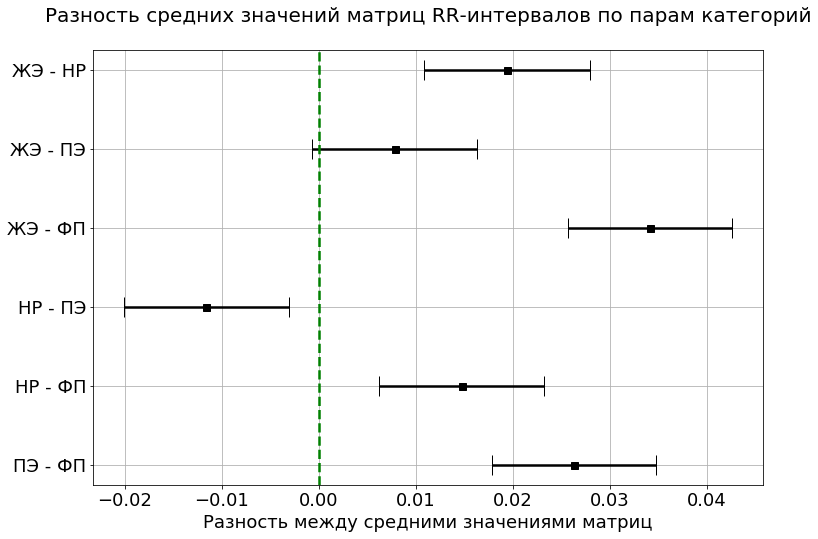

In [27]:
x_ticks = ['ЖЭ - НР', 'ЖЭ - ПЭ', 'ЖЭ - ФП', 'НР - ПЭ', 'НР - ФП', 'ПЭ - ФП'][::-1]
title_rr = 'Разность средних значений матриц RR-интервалов по парам категорий\n'
x_label_rr = 'Разность между средними значениями матриц'
tukey_test_plot(MultiComp_rr.tukeyhsd(), title_rr, x_label_rr, x_ticks)

Доверительные интервалы для средних значений.

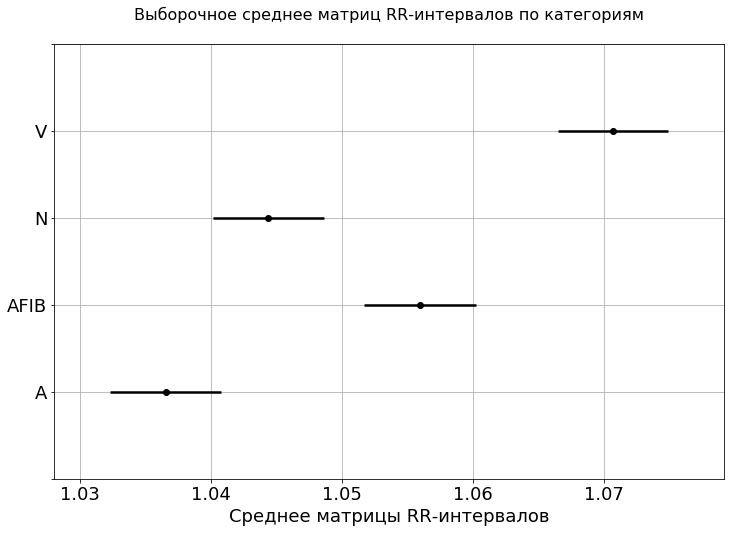

In [28]:
fig = MultiComp_rr.tukeyhsd().plot_simultaneous(figsize=(12,8))
plt.title('Выборочное среднее матриц RR-интервалов по категориям\n', fontsize=16)
plt.xlabel('Среднее матрицы RR-интервалов', fontsize=18)

plt.tick_params(axis='both', labelsize=18)
sns.set_context(rc={"lines.linewidth": 2.5})
plt.grid()
plt.show()

### Длительность QRS

In [29]:
MultiComp_duration = MultiComparison(df_features['duration'], df_features['class'])

print(MultiComp_duration.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  A     AFIB   -0.009  -0.0195 0.0015 False 
  A      N     0.0087  -0.0017 0.0191 False 
  A      V      0.06    0.0496 0.0704  True 
 AFIB    N     0.0177   0.0073 0.0282  True 
 AFIB    V     0.069    0.0586 0.0795  True 
  N      V     0.0513   0.0409 0.0617  True 
--------------------------------------------


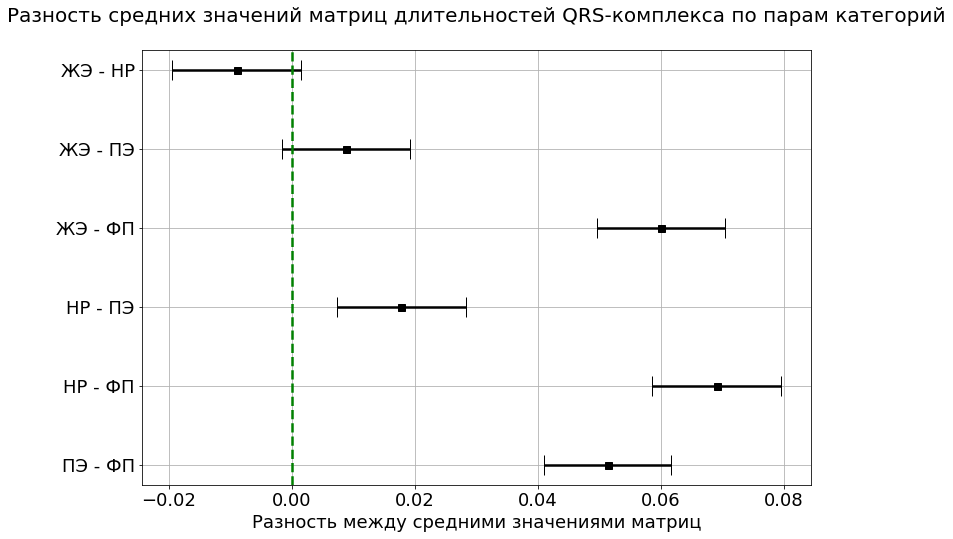

In [30]:
x_ticks = ['ЖЭ - НР', 'ЖЭ - ПЭ', 'ЖЭ - ФП', 'НР - ПЭ', 'НР - ФП', 'ПЭ - ФП'][::-1]
title_duration = 'Разность средних значений матриц длительностей QRS-комплекса по парам категорий\n'
x_label_duration = 'Разность между средними значениями матриц'
tukey_test_plot(MultiComp_duration.tukeyhsd(), title_duration, x_label_duration, x_ticks)

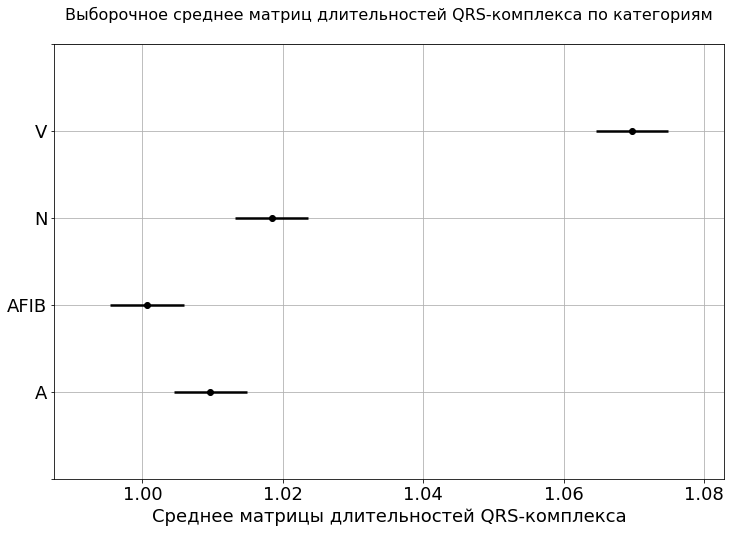

In [31]:
fig = MultiComp_duration.tukeyhsd().plot_simultaneous(figsize=(12,8))
plt.title('Выборочное среднее матриц длительностей QRS-комплекса по категориям\n', fontsize=16)
plt.xlabel('Среднее матрицы длительностей QRS-комплекса', fontsize=18)

plt.tick_params(axis='both', labelsize=18)
sns.set_context(rc={"lines.linewidth": 2.5})
plt.grid()
plt.show()

### Коэффициент формы

In [32]:
MultiComp_ff = MultiComparison(df_features['ff'], df_features['class'])

print(MultiComp_ff.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  A     AFIB   -0.018   -0.02  -0.0159  True 
  A      N    -0.0114  -0.0135 -0.0093  True 
  A      V     -0.036  -0.0381 -0.0339  True 
 AFIB    N     0.0066   0.0045  0.0086  True 
 AFIB    V     -0.018  -0.0201  -0.016  True 
  N      V    -0.0246  -0.0266 -0.0225  True 
---------------------------------------------


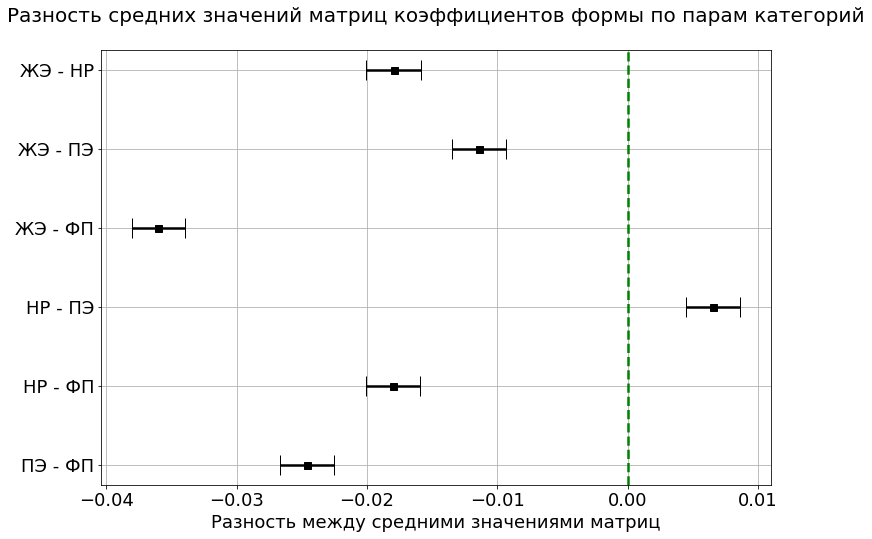

In [33]:
x_ticks = ['ЖЭ - НР', 'ЖЭ - ПЭ', 'ЖЭ - ФП', 'НР - ПЭ', 'НР - ФП', 'ПЭ - ФП'][::-1]
title_ff = 'Разность средних значений матриц коэффициентов формы по парам категорий\n'
x_label_ff = 'Разность между средними значениями матриц'
tukey_test_plot(MultiComp_ff.tukeyhsd(), title_ff, x_label_ff, x_ticks)

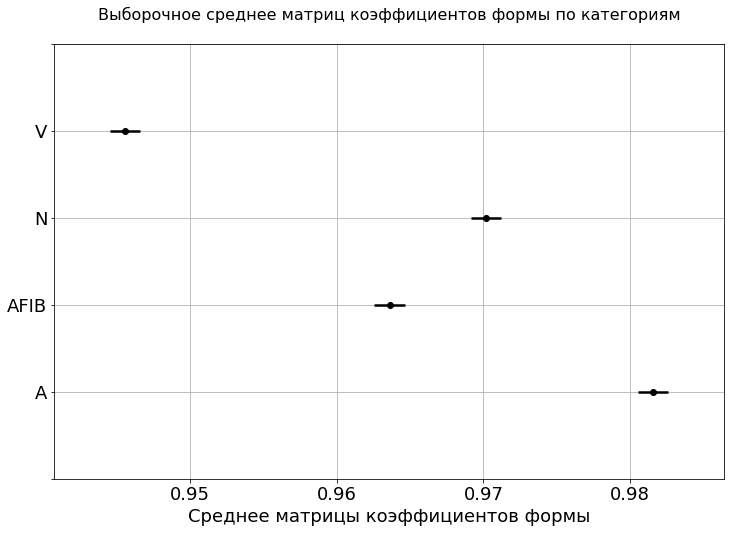

In [34]:
fig = MultiComp_ff.tukeyhsd().plot_simultaneous(figsize=(12,8))
plt.title('Выборочное среднее матриц коэффициентов формы по категориям\n', fontsize=16)
plt.xlabel('Среднее матрицы коэффициентов формы', fontsize=18)

plt.tick_params(axis='both', labelsize=18)
sns.set_context(rc={"lines.linewidth": 2.5})
plt.grid()
plt.show()

### Распределение классов в выборке

In [35]:
df_y = pd.DataFrame(y)
df_y_test = pd.DataFrame(y_test)

In [36]:
df_y[0].value_counts()

V       2282
N       2250
A       2247
AFIB    2200
Name: 0, dtype: int64

In [37]:
df_y_test[0].value_counts()

A       1020
N       1006
AFIB    1002
V        999
Name: 0, dtype: int64

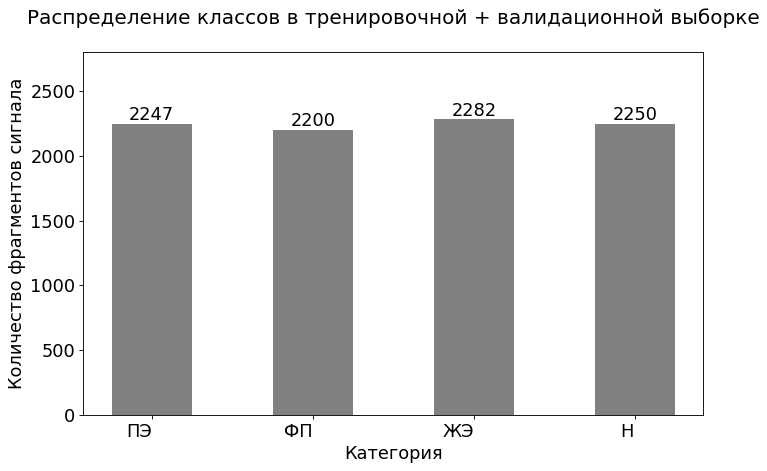

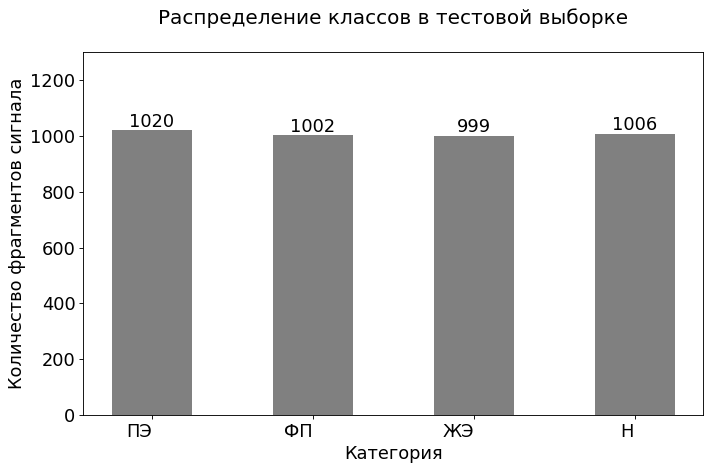

In [38]:
train_size = [2247, 2200, 2282, 2250]
test_size = [1020, 1002, 999, 1006]

n = 4
all_colors = list(plt.cm.colors.cnames.keys())
c = random.choices(all_colors, k=n)

names = ['ПЭ','ФП','ЖЭ','Н']



plt.figure(figsize=(10,6), dpi= 80)
plt.bar(names, train_size, color='grey', width=.5)
for i, val in enumerate(train_size):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})

plt.gca().set_xticklabels(names, horizontalalignment= 'right')
plt.title('Распределение классов в тренировочной + валидационной выборке\n', fontsize=18)
plt.ylabel('Количество фрагментов сигнала', fontsize=16)
plt.ylim(0, 2800)
plt.xlabel('Категория', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
fig.tight_layout()

plt.figure(figsize=(10,6), dpi= 80)
plt.bar(names, test_size, color='grey', width=.5)
for i, val in enumerate(test_size):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})

plt.gca().set_xticklabels(names, horizontalalignment= 'right')
plt.title('Распределение классов в тестовой выборке\n', fontsize=18)
plt.ylabel('Количество фрагментов сигнала', fontsize=16)
plt.ylim(0, 1300)
plt.xlabel('Категория', fontsize=16)
plt.tick_params(axis='both', labelsize=16)
fig.tight_layout()
plt.show()

In [39]:
from pandas.plotting import scatter_matrix

In [43]:
def scatter(data, col1, col2, alpha=0.75, s=0.5, ylim=[], xlim=[], cl=['N','V','A','AFIB']):
    plt.figure(figsize=(12, 8))
    if 'N' in cl:
        plt.scatter(data[col1][data['class'] == 'N'],
                    data[col2][data['class'] == 'N'],
                    alpha=alpha,
                    marker='o',
                    s=s,
                    color='green',
                    label='N')
    if 'V' in cl:
        plt.scatter(data[col1][data['class'] == 'V'],
                    data[col2][data['class'] == 'V'],
                    alpha=alpha,
                    marker='o',
                    s=s,
                    color='red',
                    label='V')
    if 'A' in cl:
        plt.scatter(data[col1][data['class'] == 'A'],
                    data[col2][data['class'] == 'A'],
                    alpha=alpha,
                    marker='o',
                    s=s,
                    color='blue',
                    label='A')
    if 'AFIB' in cl:
        plt.scatter(data[col1][data['class'] == 'AFIB'],
                    data[col2][data['class'] == 'AFIB'],
                    alpha=alpha,
                    marker='o',
                    s=s,
                    color='yellow',
                    label='AFIB')

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend(loc='best')
    if len(ylim) == 2:
        plt.ylim(ylim[0], ylim[1])
    if len(xlim) == 2:
        plt.xlim(xlim[0], xlim[1])

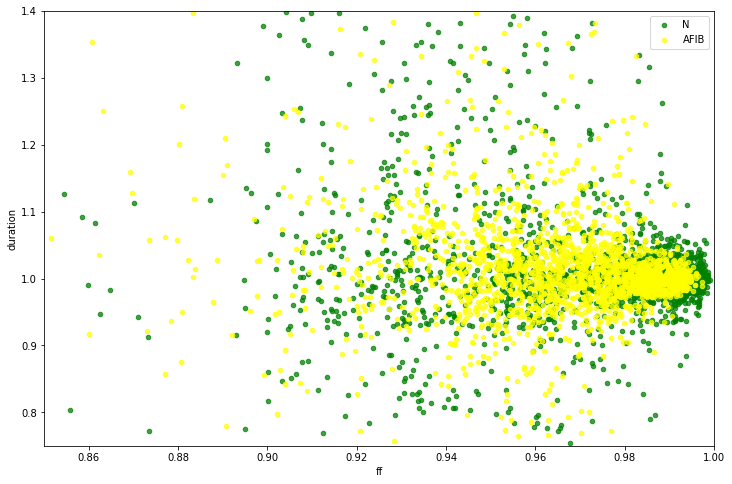

In [67]:
scatter(df_features, col1 = 'ff', col2 = 'duration', alpha=0.75, s=20.5, ylim=[0.75, 1.4], xlim=[0.85, 1.0], cl=['N', 'AFIB'])

# Обучение модели сверточной нейронной сети
Выбор сверточной нейронной сети обусловлен ее преимуществом в анализе изображений.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from catboost import CatBoostClassifier

Матрица ошибок и ее визуализация

In [5]:
def plot_confusion_matrix(cm: np.ndarray, target_names: List, title: str ='Confusion matrix', cmap = None, normalize = True):
    '''Визуализация рассчитанной матрицы ошибок.
        
    Parameters
    ----------
    cm : np.ndarray
        Готовая матрица ошибок.
        
    target_names : List
        Список классов.
        
    title : str
        Заголовок.
        
    cmap :
        Colormap.
    
    normalize : bool
        Нужна нормализация?
    '''

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar().ax.tick_params(labelsize=14)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=14,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=14,
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    plt.tick_params(axis='both', labelsize=15)
    plt.show()

In [6]:
def conf_mrtx(model, X: np.ndarray, y: np.ndarray, best: bool = False):
    '''Расчет и вызуализация матрицы ошибок.
    
    Parameters
    ----------
    model : PytorchBaseModel's instance
        Модель.
        
    X : np.ndarray
        Тестовая выборка.
        
    y : np.ndarray
        Закодированные целевые значения.
        
    best : bool
        True - модель с наименьшим значением loss
        False - модель, которая училась дальше
    '''
    target_names = ['ПЭ','ФП','Н','ЖЭ']
    
    if best:
        test_preds = model.predict(X, best=True)
    else:
        test_preds = model.predict(X, best=False)
    
    cm = confusion_matrix(y, test_preds.tolist())
    plot_confusion_matrix(cm, target_names, title='Confusion matrix\n', cmap=None, normalize=False)

Метрики

In [221]:
def f1(model, X: np.ndarray, y: np.ndarray):
    '''f1-score для лучшей и переобученной модели.
    
    Parameters
    ----------
    model : PytorchBaseModel's instance
        Модель.
        
    X : np.ndarray
        Объекты.
        
    y : np.ndarray
        Целевые значения.
        
    best : bool
        True - модель с наименьшим значением loss
        False - модель, которая училась дальше
    '''
    try:
        predict = model.predict(X, best=True)
        f1_best = f1_score(y, predict, average='weighted')
        predict = model.predict(X, best=False)
        f1_overfit = f1_score(y, predict, average='weighted')
        print(f'f1-score for the best model:              {f1_best}')
        print(f'f1-score for the model at the last epoch: {f1_overfit}')
    except:
        predict = model.predict(X, best=False)
        f1_overfit = f1_score(y, predict, average='weighted')
        print(f'f1-score for the model at the last epoch: {f1_overfit}')

In [8]:
def report(model, X: np.ndarray, y: np.ndarray, best: bool = False):
    '''Sklearn classification report.
    
    Parameters
    ----------
    model : PytorchBaseModel's instance
        Модель.
        
    X : np.ndarray
        Тестовая выборка.
        
    y : np.ndarray
        Закодированные целевые значения.
        
    best : bool
        True - модель с наименьшим значением loss
        False - модель, которая училась дальше
    '''
    target_names = ['ПЭ','ФП','Н','ЖЭ']
    
    if best:
        predict = model.predict(X, best=True)
    else:
        predict = model.predict(X, best=False)

    print(classification_report(y, predict.tolist(), target_names=target_names))

Графики истории обучения

In [9]:
def plot_history(model):
    '''Графики истории обучения.
    
    Parameters
    ----------
    model : PytorchBaseModel's instance
        Модель.
        
    '''
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    try:
        axes[0].plot(model.val_loss_history, label = 'val_loss')
        axes[0].plot(model.train_loss_history, label = 'train_loss')
        axes[0].scatter(model.best_epoch, model.val_loss_history[model.best_epoch], s=40)
        axes[0].scatter(model.best_epoch, model.train_loss_history[model.best_epoch], s=40)
        axes[0].axvline(model.best_epoch, color='g', label=f'best epoch: {model.best_epoch}').set_linestyle('--')
    except:
        axes[0].plot(model.train_loss_history, label = 'train_loss', color = 'orange')
    
    axes[0].set_title('Loss history', fontsize=14)
    axes[0].set_xlabel('№ epoch', fontsize=12)
    axes[0].set_ylabel('loss', fontsize=12)
    axes[0].tick_params(axis='both', labelsize=12)
    axes[0].legend(loc='best', fontsize=12)
    axes[0].grid()
    
    try:
        axes[1].plot(model.val_accuracy_history, label = 'val_accuracy')
        axes[1].plot(model.train_accuracy_history, label = 'train_accuracy')
        axes[1].scatter(model.best_epoch, model.val_accuracy_history[model.best_epoch], s=40)
        axes[1].scatter(model.best_epoch, model.train_accuracy_history[model.best_epoch], s=40)
        axes[1].axvline(model.best_epoch, color='g', label=f'best epoch: {model.best_epoch}').set_linestyle('--')
    except:
        axes[1].plot(model.train_accuracy_history, label = 'train_accuracy', color = 'orange')
    
    axes[1].set_title('Accuracy history', fontsize=14)
    axes[1].set_xlabel('№ epoch', fontsize=12)
    axes[1].set_ylabel('accuracy', fontsize=12)
    axes[1].tick_params(axis='both', labelsize=12)
    axes[1].legend(loc='best', fontsize=12)
    axes[1].grid()
    plt.tight_layout()
    plt.show()

Фиксация seed для воспроизводимости результатов

In [10]:
def seed_fixation(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_fixation(0)

### Исходные данные

Datasets:
- X_mtrx
- y_mtrx
- X_test_mtrx
- y_test_mtrx

Разделение на train и validation будет происходить внутри экземпляра класса PytorchBaseModel при обучении. Закодируем целевую переменную.

In [11]:
encoder = LabelEncoder()
y_mtrx_enc = encoder.fit_transform(y_mtrx)
y_test_mtrx_enc = encoder.transform(y_test_mtrx)

### Базовый класс для PyTorch моделей

In [12]:
class PytorchBaseModel(BaseEstimator):
    def __init__(self, net_constructor, net_params: Dict, optim_constructor, optim_params: Dict, loss_func,
                 batch_size: int, stop_criterion: int = 5, cuda: bool = True):
        '''Базовый класс для взаимодействия с sklearn.
        
        Parameters
        ----------
        net_constructor
            Конструктор модели.
            
        net_params : Dict
            Словарь параметров модели.
            
        optim_constructor
            Конструктор оптимизатора.
            
        optim_params : Dict
            Словарь параметров оптимизатора.
        
        loss_func
            Функция потерь.
            
        batch_size: int
            Размер батча.
        
        stop_criterion : int
            Количество эпох для стратегии early stopping
        
        cuda : bool
            Перенести вычисления на GPU?
        '''
        self.net_constructor = net_constructor
        self.net_params = net_params
        self.optim_constructor = optim_constructor
        self.optim_params = optim_params
        self.loss_func = loss_func
        self.batch_size = batch_size
        self.stop_criterion = stop_criterion
        self.cuda = cuda
    
    
    def fit(self, X, y, split=False, check_epochs=False):
        self.net = self.net_constructor(**self.net_params)
        
        if self.cuda:
            self.net = self.net.cuda()
        
        self.optim = self.optim_constructor(self.net.parameters(), **self.optim_params)
        
        # sklearn требует наличие 'classes_'
        self.classes_ = np.sort(np.unique(y))
        
        if split:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
        else:
            X_train = X
            y_train = y

        X_train = torch.FloatTensor(X_train)
        y_train = torch.LongTensor(y_train)
        
        if split:
            X_val = torch.FloatTensor(X_val)        
            y_val = torch.LongTensor(y_val)

        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            
        train_accuracy_history = []
        train_loss_history = []
        val_accuracy_history = []
        val_loss_history = []
        
        current_epoch = -1
        
        while True:
            self.net.train()
            current_epoch += 1
            
            for batch in train_loader:
                self.optim.zero_grad()
                
                X_batch = batch[0]
                y_batch = batch[1]
                
                if self.cuda:
                    X_batch = X_batch.cuda()
                    y_batch = y_batch.cuda()

                y_pred = self.net(X_batch)
                loss_value = self.loss_func(y_pred, y_batch)
                loss_value.backward()
                
                self.optim.step()
                
            self.net.eval()
            
            train_preds = self.net(X_train)
            train_accuracy = (train_preds.argmax(dim=1) == y_train).float().mean().data.cpu()
            train_accuracy_history.append(train_accuracy)
            train_loss_history.append(self.loss_func(train_preds, y_train).data.cpu())
            
            if split:
                val_preds = self.net(X_val)
                val_accuracy = (val_preds.argmax(dim=1) == y_val).float().mean().data.cpu()
                val_accuracy_history.append(val_accuracy)
                val_loss_history.append(self.loss_func(val_preds, y_val).data.cpu())

            if check_epochs:
                if split:
                    print(f'{current_epoch} -- train acc: {round(train_accuracy.item(), 5)},'+ \
                          f' val acc: {round(val_accuracy.item(), 5)}')
                else:
                    print(f'{current_epoch} -- train acc: {round(train_accuracy.item(), 5)}')
            
            
            DIFFERENCE = 0.02
            THRESHOLD = 5
            
            # Early stopping
            if split:
                # Наблюдаем за loss на валидации                
                current_argmin = np.argmin(val_loss_history)

                # Сохранение модели на эпохе с минимальным loss
                if current_argmin == current_epoch:
                    torch.save(self.net.state_dict(), 'checkpoint.pth')

                if current_epoch - current_argmin >= self.stop_criterion:
                    # История
                    self.train_accuracy_history = train_accuracy_history
                    self.val_accuracy_history = val_accuracy_history
                    self.train_loss_history = train_loss_history
                    self.val_loss_history = val_loss_history
                    self.best_epoch = current_argmin

                    # Загрузка лучшей модели
                    self.best_estimator = self.net_constructor(**self.net_params)
                    self.best_estimator.load_state_dict(torch.load('checkpoint.pth'))
                    self.best_estimator.eval()
                    break
            else:
                # Наблюдаем за accuracy на train
                if current_epoch > THRESHOLD:
                    slice_epoch = train_loss_history[-THRESHOLD:]
                    if np.max(slice_epoch) - np.min(slice_epoch) < DIFFERENCE:
                        # История
                        self.train_accuracy_history = train_accuracy_history
                        self.train_loss_history = train_loss_history
                        break
    
    def predict_proba(self, X, best=False):
        '''Предсказание вероятности класса.
        
        best - выбор модели с наименьшей loss func
        '''
        X_t = torch.FloatTensor(X)
        
        if self.cuda:
            X_t = X_t.cuda()
        
        if best:
            try:
                self.best_estimator.eval()
                predictions = F.softmax(self.best_estimator(X_t)).detach().numpy()
            except:
                return
            
            return predictions
        else:
            self.net.eval()
            predictions = F.softmax(self.net(X_t)).detach().numpy()
            
            return predictions

    
    def predict(self, X, best=False):
        '''Предсказание класса.
        
        best - выбор модели с наименьшей loss func
        '''
        try:
            X_t = torch.FloatTensor(X)
            predictions = self.predict_proba(X_t, best).argmax(axis=1)
        except:
            return
        
        return predictions

### CNN: input shape 3x6x6.

In [48]:
class EcgNet(nn.Module):
    def __init__(self, num_chanel: int = 10, num_conv: int = 1, drop: bool = False):
        '''Конструктор CNN.
        
        Parameters
        ----------
        num_chanel : int
            Число каналов свертки.
            
        num_conv : int
            Число сверток.
            
        drop : bool
            Нужен дропаут? Выбрано значение 0.75.
        '''
        super(EcgNet, self).__init__()
        self.num_chanel = num_chanel
        self.drop = drop
        self.num_conv = num_conv
        
        self.bn0 = nn.BatchNorm2d(num_features=3)
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=self.num_chanel, kernel_size=3, padding=1)
        self.act1  = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm2d(self.num_chanel)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        if self.drop == True:
            self.dropout1 = nn.Dropout(0.25)
        
        if self.num_conv == 2 or self.num_conv == 3:
            self.conv2 = nn.Conv2d(
                in_channels=self.num_chanel, out_channels=self.num_chanel*2, kernel_size=3, padding=1)
            self.act2  = nn.ReLU()
            self.batch_norm2 = nn.BatchNorm2d(self.num_chanel*2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
            if self.drop == True:
                self.dropout2 = nn.Dropout(0.25)
                
        if self.num_conv == 3:
            self.conv3 = nn.Conv2d(
                in_channels=self.num_chanel*2, out_channels=self.num_chanel*3, kernel_size=3, padding=1)
            self.act3 = nn.ReLU()
            self.batch_norm3 = nn.BatchNorm2d(self.num_chanel*3)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)
            if self.drop == True:
                self.dropout3 = nn.Dropout(0.25)
        
        self.fc1   = nn.Linear((6 - self.num_conv) * (6 - self.num_conv) * self.num_chanel * self.num_conv, 256)
        self.act4  = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm1d(256)
        
        self.fc2   = nn.Linear(256, 64)
        self.act5  = nn.ReLU()
        self.batch_norm5 = nn.BatchNorm1d(64)
        
        self.fc3   = nn.Linear(64, 4)
    
    
    def forward(self, x):
        x = self.bn0(x)
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.batch_norm1(x)
        x = self.pool1(x)
        if self.drop == True:
            x = self.dropout1(x)
        
        if self.num_conv == 2 or self.num_conv == 3:
            x = self.conv2(x)
            x = self.act2(x)
            x = self.batch_norm2(x)
            x = self.pool2(x)
            if self.drop == True:
                x = self.dropout2(x)

        if self.num_conv == 3:
            x = self.conv3(x)
            x = self.act3(x)
            x = self.batch_norm3(x)
            x = self.pool3(x)
            if self.drop == True:
                x = self.dropout3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.batch_norm4(x)
        
        x = self.fc2(x)
        x = self.act5(x)
        x = self.batch_norm5(x)
        
        x = self.fc3(x)
        
        return x

Обучение с базовым набором параметров

In [364]:
CNN_model = PytorchBaseModel(net_constructor=EcgNet, net_params={'num_conv': 2, 'drop': True},
                              optim_constructor=torch.optim.Adam, optim_params={'lr': 1.0e-3},
                              loss_func=nn.CrossEntropyLoss(), batch_size=73,
                              stop_criterion=7, cuda=False)

In [365]:
CNN_model.fit(X_mtrx, y_mtrx_enc, split=True, check_epochs=True)

0 -- train acc: 0.86468, val acc: 0.85635
1 -- train acc: 0.8825, val acc: 0.87305
2 -- train acc: 0.88584, val acc: 0.87194
3 -- train acc: 0.8999, val acc: 0.88252
4 -- train acc: 0.90102, val acc: 0.88586
5 -- train acc: 0.89795, val acc: 0.87973
6 -- train acc: 0.90603, val acc: 0.8892
7 -- train acc: 0.9102, val acc: 0.89198
8 -- train acc: 0.9077, val acc: 0.88641
9 -- train acc: 0.90352, val acc: 0.87806
10 -- train acc: 0.91661, val acc: 0.89421
11 -- train acc: 0.91341, val acc: 0.88864
12 -- train acc: 0.90812, val acc: 0.87862
13 -- train acc: 0.91744, val acc: 0.89031
14 -- train acc: 0.92427, val acc: 0.89588
15 -- train acc: 0.92914, val acc: 0.89922
16 -- train acc: 0.93081, val acc: 0.90089
17 -- train acc: 0.92775, val acc: 0.89699
18 -- train acc: 0.92997, val acc: 0.89087
19 -- train acc: 0.93457, val acc: 0.89922
20 -- train acc: 0.93763, val acc: 0.89421
21 -- train acc: 0.93735, val acc: 0.89866
22 -- train acc: 0.93624, val acc: 0.90145
23 -- train acc: 0.94209, 

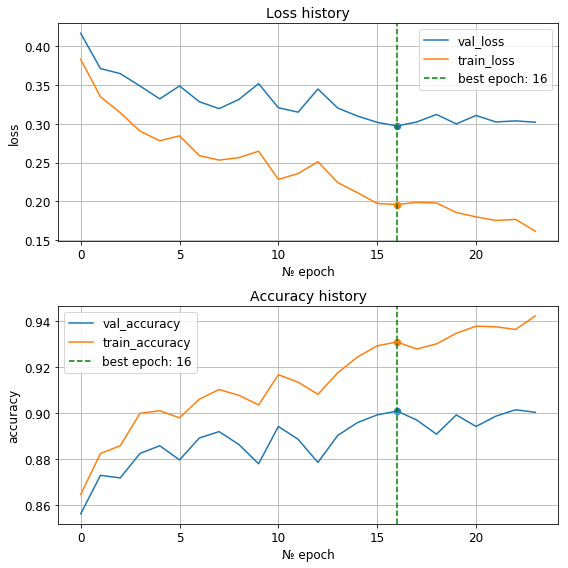

In [366]:
plot_history(CNN_model)

Оценим модель на тестовой выборке

In [420]:
f1(CNN_model, X_test_mtrx, y_test_mtrx_enc)

f1-score for best model:    0.8555308281019528
f1-score for overfit model: 0.8402161316355571


In [368]:
report(CNN_model, X_test_mtrx, y_test_mtrx_enc, best=True)

              precision    recall  f1-score   support

          ПЭ       0.84      0.85      0.85      1020
          ФП       0.83      0.84      0.84      1002
           Н       0.88      0.88      0.88      1006
          ЖЭ       0.87      0.84      0.86       999

   micro avg       0.86      0.86      0.86      4027
   macro avg       0.86      0.86      0.86      4027
weighted avg       0.86      0.86      0.86      4027



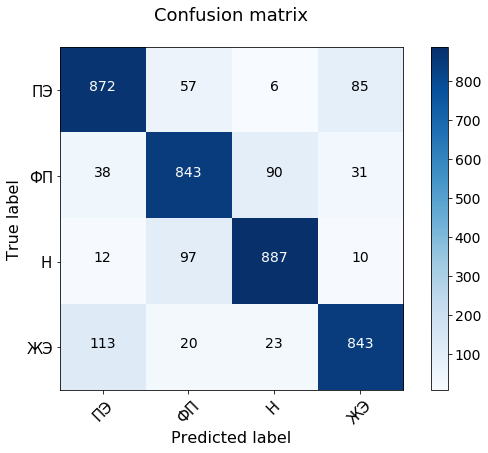

In [369]:
conf_mrtx(CNN_model, X_test_mtrx, y_test_mtrx_enc, best=True)

Получен неплохой результат с f1-score = 0.8555. Попробуем оптимизировать число блоков со сверткой и количество каналов свертки. Хорошо показал себя дропаут, который улучшает результат модели при тестировании, будем использовать его.

### Grid search

In [49]:
CNN_model_2 = PytorchBaseModel(net_constructor=EcgNet, net_params={},
                               optim_constructor=torch.optim.Adam,
                               optim_params={'lr': 1.0e-3},
                               loss_func=nn.CrossEntropyLoss(), 
                               batch_size=73,
                               stop_criterion=4, cuda=False)

In [50]:
cnn_grid = {
    'net_params': [{'num_chanel': 10, 'num_conv': 1, 'drop': True},
                   {'num_chanel': 10, 'num_conv': 2, 'drop': True},
                   {'num_chanel': 10, 'num_conv': 3, 'drop': True},
                   {'num_chanel': 15, 'num_conv': 1, 'drop': True},
                   {'num_chanel': 15, 'num_conv': 2, 'drop': True},
                   {'num_chanel': 15, 'num_conv': 3, 'drop': True}]
}

In [51]:
cnn_gs = GridSearchCV(CNN_model_2,
                      cnn_grid,
                      scoring='f1_weighted',
                      cv=StratifiedKFold(n_splits=4),
                      return_train_score=True,
                      verbose=100)

cnn_gs.fit(X_mtrx, y_mtrx_enc)

Fitting 4 folds for each of 6 candidates, totalling 24 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True} ......
[CV]  net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True}, score=0.8740151269119756, total=  29.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s remaining:    0.0s
[CV] net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True} ......
[CV]  net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True}, score=0.8101807047452887, total=  24.1s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   54.2s remaining:    0.0s
[CV] net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True} ......
[CV]  net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True}, score=0.8632011370664401, total=  25.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[CV] net_params={'num_chanel': 10, 'num_conv': 1, 'drop': True} ......
[CV]  net_params=

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=PytorchBaseModel(batch_size=73, cuda=False, loss_func=CrossEntropyLoss(),
         net_constructor=<class '__main__.EcgNet'>,
         net_params={'num_conv': 2, 'drop': True},
         optim_constructor=<class 'torch.optim.adam.Adam'>,
         optim_params={'lr': 0.001}, stop_criterion=4),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'net_params': [{'num_chanel': 10, 'num_conv': 1, 'drop': True}, {'num_chanel': 10, 'num_conv': 2, 'drop': True}, {'num_chanel': 10, 'num_conv': 3, 'drop': True}, {'num_chanel': 15, 'num_conv': 1, 'drop': True}, {'num_chanel': 15, 'num_conv': 2, 'drop': True}, {'num_chanel': 15, 'num_conv': 3, 'drop': True}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1_weighted', verbose=100)

In [53]:
cnn_gs.best_params_

{'net_params': {'num_chanel': 15, 'num_conv': 3, 'drop': True}}

In [58]:
cnn_gs.best_score_

0.8505525640008019

Оценка на тестовой выборке

In [55]:
f1(cnn_gs.best_estimator_, X_test_mtrx, y_test_mtrx_enc)

f1-score for overfit model: 0.8524568349477354


Результат оказался немного хуже. Переобучим сеть с теми же параметрами, но применяя early stopping по валидации.

In [104]:
CNN_best = PytorchBaseModel(net_constructor=EcgNet, net_params={'num_chanel': 15, 'num_conv': 3, 'drop': True},
                              optim_constructor=torch.optim.Adam, optim_params={'lr': 1.0e-3},
                              loss_func=nn.CrossEntropyLoss(), batch_size=73,
                              stop_criterion=10, cuda=False)

In [105]:
CNN_best.fit(X_mtrx, y_mtrx_enc, split=True)

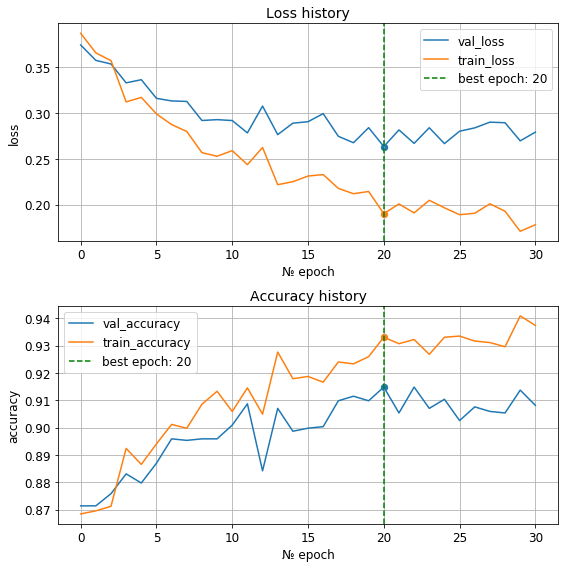

In [106]:
plot_history(CNN_best)

In [108]:
f1(CNN_best, X_test_mtrx, y_test_mtrx_enc)

f1-score for the best model:              0.8578065286879406
f1-score for the model at the last epoch: 0.854239477636627


Сохраним итоговую модель

In [110]:
torch.save(CNN_best.best_estimator, 'CNN_best_net.pth')

### Вывод

**CNN f1-score 0.857806**

Сверточная нейронная сеть показала хороший результат. Его можно улучшить путем перебора других гиперпараметров, например вид оптимизатора и его настройки. Также может помочь выбор другого критерия останова и применение планировщика для управления learning rate.

Ограниченная точность классификатора также обусловена неидельностью методов выделения признаков из сигнала ЭКГ.

# Применение других моделей машинного обучения

## Исходные данные и их анализ

Значения под главной диагональю матрицы признаков (45 признаков):
- X_experiment
- y_experiment
- X_experiment_test
- y_experiment_test

In [13]:
X = X_experiment
y = y_experiment
X_test = X_experiment_test
y_test = y_experiment_test

Кодирование целевой переменной и формирование DataFrame

In [14]:
# Кодирование
encoder = LabelEncoder()
y_enc = encoder.fit_transform(y)
y_test_enc = encoder.transform(y_test)

# Формирование DataFrame
columns = ['Duration' + str(i) for i in range(1, 16)] + \
          ['FF' + str(i) for i in range(1, 16)] + \
          ['RR' + str(i) for i in range(1, 16)]

df_X = pd.DataFrame(X, columns=columns)
df_X_test = pd.DataFrame(X_test, columns=columns)

# Первые 5 строк
df_X.head(5)

,Duration1,Duration2,Duration3,Duration4,Duration5,Duration6,Duration7,Duration8,Duration9,Duration10,...,RR6,RR7,RR8,RR9,RR10,RR11,RR12,RR13,RR14,RR15
0,1.045017,1.101016,1.053586,1.559204,1.492036,1.416150,1.002382,0.959201,0.910416,0.642881,...,0.658703,1.448399,1.433099,1.389078,2.108808,1.007117,0.996479,0.965870,1.466321,0.695332
1,1.000554,0.989494,0.988947,1.353079,1.352330,1.367445,1.032766,1.032195,1.043731,0.763271,...,0.562500,1.323077,1.268437,1.279762,2.275132,1.006154,0.964602,0.973214,1.730159,0.760465
2,1.002883,0.994114,0.991256,1.124395,1.121163,1.131053,1.008666,1.005766,1.014638,0.897074,...,0.477778,1.398671,1.249258,1.169444,2.447674,1.132890,1.011869,0.947222,1.982558,0.809976
3,0.982524,1.012067,1.030068,1.307813,1.331075,1.292220,1.072649,1.091728,1.059859,0.820185,...,0.609836,1.295820,1.312704,1.321311,2.166667,0.971061,0.983713,0.990164,1.623656,0.749380
4,1.002155,0.997532,0.995386,1.229779,1.227135,1.232823,1.041603,1.039363,1.044181,0.846984,...,0.633898,1.093583,1.450355,1.386441,2.187166,0.745989,0.989362,0.945763,1.491979,0.682152


In [15]:
df_X.describe().T

,count,mean,std,min,25%,50%,75%,max
Duration1,8979.0,1.007142,0.250321,0.000000,0.970618,0.999550,1.027202,6.119900
Duration2,8979.0,1.006397,0.262862,0.000000,0.969448,0.999413,1.028806,6.151729
Duration3,8979.0,1.006298,0.248237,0.000000,0.971531,0.999924,1.028198,6.119900
Duration4,8979.0,1.125877,0.435659,0.000000,0.968623,1.005888,1.098380,5.735202
Duration5,8979.0,1.127003,0.439748,0.000000,0.969973,1.005479,1.095279,6.151729
Duration6,8979.0,1.128341,0.436797,0.000000,0.971164,1.004685,1.091901,6.119900
Duration7,8979.0,1.008642,0.276198,0.000000,0.970652,1.000131,1.030937,8.065335
Duration8,8979.0,1.008690,0.256379,0.000000,0.969711,1.000257,1.032028,6.100090
Duration9,8979.0,1.011284,0.278841,0.000000,0.971141,1.000281,1.031506,6.725711
Duration10,8979.0,0.951611,0.362528,0.000000,0.908084,0.993525,1.029482,20.124483


Количественная оценка типов данных

In [16]:
df_X.dtypes.value_counts()

float64    45
dtype: int64

Присутствуют нулевые значения и выбросы. Оценим их количество.

### Работа с нулевыми значениями
Тренировочная выборка

Всего объектов в тренировочной выборке: 8979
Количество строк с хотя бы одним нулем в тренировочной выборке: 182
Наибольшее число нулей в строке из тренировочной выборки: 15


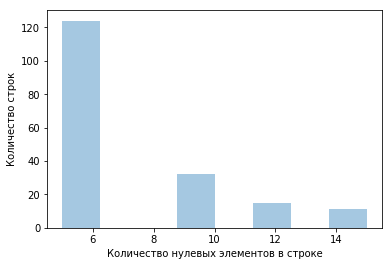

In [17]:
print(f'Всего объектов в тренировочной выборке: {df_X.shape[0]}')

null_row = ((df_X == 0).sum(axis=1) > 0).sum()
print(f'Количество строк с хотя бы одним нулем в тренировочной выборке: {null_row}')

max_num_null = (df_X == 0).sum(axis=1).max()
print(f'Наибольшее число нулей в строке из тренировочной выборки: {max_num_null}')

# Гистограмма
null_hist = (df_X == 0).sum(axis=1).to_numpy()
null_hist = null_hist[null_hist > 0]

sns.distplot(null_hist, kde=False)
plt.xlabel('Количество нулевых элементов в строке')
plt.ylabel('Количество строк')
plt.show()

Тестовая выборка

Всего объектов в тестовой выборке: 4027
Количество строк с хотя бы одним нулем в тестовой выборке: 95
Наибольшее число нулей в строке из тестовой выборки: 15


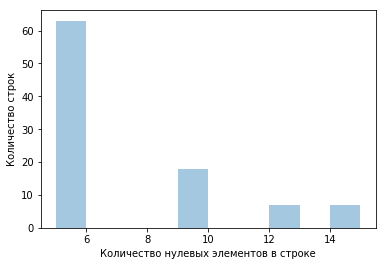

In [18]:
print(f'Всего объектов в тестовой выборке: {df_X_test.shape[0]}')

null_row_test = ((df_X_test == 0).sum(axis=1) > 0).sum()
print(f'Количество строк с хотя бы одним нулем в тестовой выборке: {null_row_test}')

max_num_null_test = (df_X_test == 0).sum(axis=1).max()
print(f'Наибольшее число нулей в строке из тестовой выборки: {max_num_null_test}')

# Гистограмма
null_hist_test = (df_X_test == 0).sum(axis=1).to_numpy()
null_hist_test = null_hist_test[null_hist_test > 0]

sns.distplot(null_hist_test, kde=False, bins=10)
plt.xlabel('Количество нулевых элементов в строке')
plt.ylabel('Количество строк')
plt.show()

Заменим нулевые значения медианой по столбцам

In [19]:
df_X = df_X.apply(lambda x: x.replace(0, x.median()))

df_X_test = df_X_test.apply(lambda x: x.replace(0, x.median()))

In [20]:
# Проверка
null_row = ((df_X == 0).sum(axis=1) > 0).sum()
print(f'Количество строк с хотя бы одним нулем в тренировочной выборке: {null_row}')

null_row_test = ((df_X_test == 0).sum(axis=1) > 0).sum()
print(f'Количество строк с хотя бы одним нулем в тестовой выборке: {null_row_test}')

Количество строк с хотя бы одним нулем в тренировочной выборке: 0
Количество строк с хотя бы одним нулем в тестовой выборке: 0


### Работа с выбросами

Будем считать выбросами числа для которых z-значение больше 3.

In [21]:
# Расчет z-scrore
num_outliers_train = (np.abs(stats.zscore(df_X)) > 3).sum(axis=1).sum()
num_outliers_test = (np.abs(stats.zscore(df_X_test)) > 3).sum(axis=1).sum()

# Количество значений в датафреймах
total_num_train = df_X.shape[0] * df_X.shape[1]
total_num_test = df_X_test.shape[0] * df_X_test.shape[1]

print(f'Количество элементов тренировочной выборки с z-значением больше 3: {num_outliers_train} из {total_num_train}' + \
      f' -- {round(num_outliers_train/total_num_train*100, 2)}%')

print(f'Количество элементов тестовой выборки с z-значением больше 3: {num_outliers_test} из {total_num_test}' + \
      f' -- {round(num_outliers_test/total_num_test*100, 2)}%')

Количество элементов тренировочной выборки с z-значением больше 3: 7715 из 404055 -- 1.91%
Количество элементов тестовой выборки с z-значением больше 3: 2733 из 181215 -- 1.51%


Наблюдается умеренное количество выбросов. Посмотрим на распределение числа выбросов в строках.

Train

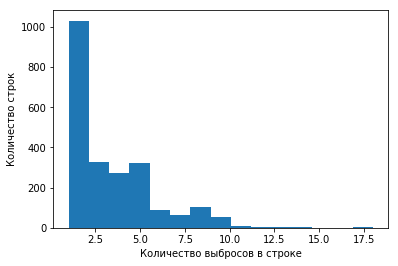

In [22]:
outliers_in_rows_train = (np.abs(stats.zscore(df_X)) > 3).sum(axis=1)
outliers_in_rows_hist = outliers_in_rows_train[outliers_in_rows_train > 0]
plt.hist(outliers_in_rows_hist, bins=15)
plt.xlabel('Количество выбросов в строке')
plt.ylabel('Количество строк')
plt.show()

Test

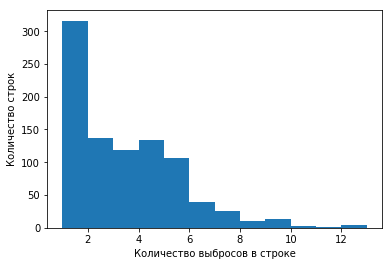

In [23]:
outliers_in_rows_test = (np.abs(stats.zscore(df_X_test)) > 3).sum(axis=1)
outliers_in_rows_hist_test = outliers_in_rows_test[outliers_in_rows_test > 0]
plt.hist(outliers_in_rows_hist_test, bins=12)
plt.xlabel('Количество выбросов в строке')
plt.ylabel('Количество строк')
plt.show()

Не будем удалять строки. Заменим все выбросы на медиану

In [24]:
def outliers_to_meadian(col):
    col[np.abs(stats.zscore(col)) > 3] = col.median()
    return col

In [25]:
df_X = df_X.apply(outliers_to_meadian)
df_X_test = df_X_test.apply(outliers_to_meadian)

Проверка наличия None

In [26]:
df_X.isnull().values.any()

False

In [27]:
df_X_test.isnull().values.any()

False

## Feature Selection

### RF Feature importance

In [28]:
def RF_importance(X: Sequence[Any], y: Sequence[Any], n_sample: int = 1) -> pd.DataFrame:
    '''Расчет важности признаков с помощью случайного леса.
    
    Parameters
    ----------
    X : Sequence[Any]
        Обучающая выборка.
    
    y : Sequence[Any]
        Таргет.
        
    n_sample : int , default = 1
        Количество повторных расчетов важности для усреднения.
        
    Returns
    -------
    pd.DataFrame - columns=['feature', 'importance']
    '''
    # Массив нулей для усреднения
    importance = np.zeros(X.shape[1])
    
    names = X.columns.values

    for i in range(n_sample):
        try:
            rfc = RandomForestClassifier()
        except:
            print('RandomForestClassifier is not imported or has a different name')
            return
        
        rfc.fit(X, y)

        importance += rfc.feature_importances_

    df_importance = pd.DataFrame({'feature': X.columns.values, 'importance': importance / n_sample})
    
    return df_importance.sort_values('importance', ascending=False).reset_index(drop=True)

In [29]:
importance_test = RF_importance(df_X, y_enc, n_sample=10)

In [30]:
def importance_plot(importance: pd.DataFrame, num_features: int = None):
    '''Визуализация важности признаков.
    
    Parameters
    ----------
    importance : pd.DataFrame
        Датафрейм с названием признаков и их важностью.
    
    num_features : int, default = None (all features)
        Число признаков.
    '''
    if num_features != None:
        figsize = (12, 12 * num_features / importance.shape[0])
        importance = importance.iloc[:num_features, :]
    else:
        figsize = (12, 10)
    reverse_df = importance.sort_values('importance', ascending=True)

    # Порог отсечения - 10 % от самого важного признака
    TRH = reverse_df['importance'].max() * 0.1
    reverse_df['color'] = ['red' if importance < TRH else 'green' for importance in reverse_df['importance']]
    
    plt.figure(figsize=figsize, dpi= 80)
    plt.hlines(y=reverse_df['feature'], xmin=0, xmax=reverse_df['importance'])
    for x, y, tex in zip(reverse_df['importance'], reverse_df['feature'], reverse_df['importance']):
        t = plt.text(x, y, round(tex, 3), horizontalalignment='left', 
                     verticalalignment='center', fontdict={'color':'red' if x < TRH else 'green', 'size':11})


    plt.title('RF Feature importance', fontsize=20)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlim(0, 1.15 * reverse_df['importance'].max())
    plt.tight_layout()
    plt.show()

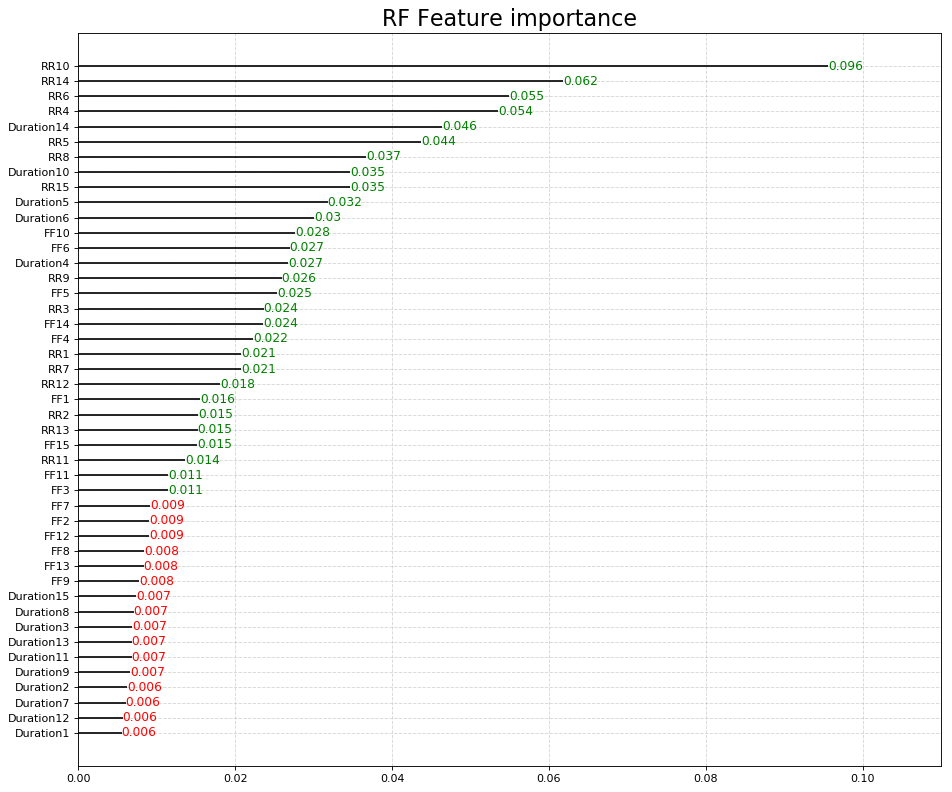

In [31]:
importance_plot(importance_test)

In [32]:
col_importance = importance_test['feature']

In [112]:
def importance_split(number_of_features: int, num_splits: int) -> np.ndarray:
    '''Границы отсечения количества признаков для испытания.
    
    Parameters
    ----------
    number_of_features : int
        Количество признаков.
        
    num_parts : int
        Число разбиений.
        
    Returns
    -------
    np.ndarray
        Числа из последовательности 2^n.
    '''
    x = np.linspace(np.log2(2), np.log2(number_of_features), num_splits)
    y = np.array(list(set(map(int, 2 ** x))))
    
    return np.sort(y)

In [117]:
importance_split(col_importance.shape[0], 10)

array([ 2,  3,  5,  7, 11, 15, 22, 31, 45])

Видно, что наиболее информативным признаком является длительность RR-интервалов. Это объясняется физиологией рассматриваемых патологий. Существует индивидуальное отличие каждого события в значении RR-интервалов.

### PCA

Снизим размерность данных и оценим распределение классов.

In [35]:
def PCA_visualization(X: Sequence[Any], y: Sequence[Any]):
    '''Снижение размерности данных до двух компонент и их визуализация.
    
    Parameters
    ----------
    X : Sequence[Any]
        Обучающая выборка.
    
    y : Sequence[Any]
        Таргет.
    '''
    pca = PCA(n_components=2)

    reduced_data = pca.fit_transform(X, y)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = ['seagreen', 'indigo', 'tab:blue', 'gold']

    for name in np.unique(y_enc)[::-1]:
        ax.scatter(reduced_data[:,0][y_enc == name], reduced_data[:,1][y_enc == name],
                   c=colors[name], alpha=0.75, label=encoder.classes_[name])

    ax.legend()
    plt.title('PCA result', fontsize=16)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)

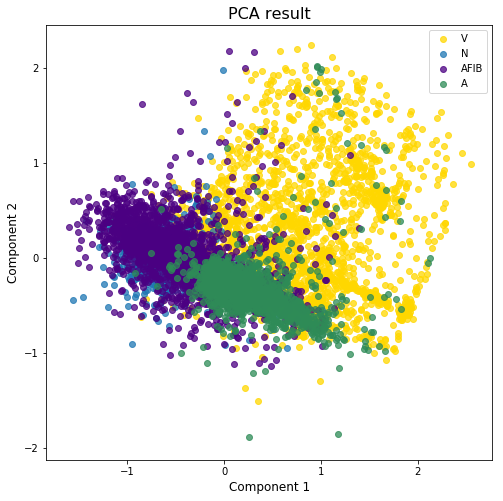

In [36]:
PCA_visualization(df_X, y_enc)

ЖЭ образуют отчетливый кластер, который отделяется от других. ФП и ПЭ накладываются друг на друга. В целом есть надежда на то, что задача классификации решаема.

## Обучение моделей

**Нормирование данных**

In [37]:
def normalize(X_train, X_val = None, X_test = None, scaler_type: str = 'standard',
              non_num_features: Sequence[str] = []) -> pd.DataFrame:
    '''Нормирование данных с момощью выбранной стратегии
    
    Parameters
    ----------
    X_train, X_val, X_test : pd.DataFrame
        Выборки.
        
    scaler_type : str, default = 'standard'
        Стратегия нормализации.
        
    non_num_features : Sequence[str], default = None
        Список имен НЕ количественных переменных.
    
    Returns
    -------
    X_train, X_val, X_test : pd.DataFrame
        Нормированные данные.
    '''
    
    numerical_features = [feat for feat in X_train.columns if feat not in non_num_features]

    if scaler_type == 'min_max':
        scaler = preprocessing.MinMaxScaler()
    elif scaler_type == 'robust':
        scaler = preprocessing.RobustScaler()
    elif scaler_type == 'standard':
        scaler = preprocessing.StandardScaler()
    elif scaler_type == 'max_abs':
        scaler = preprocessing.MaxAbsScaler()
        
    X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    X_val[numerical_features] = scaler.transform(X_val[numerical_features])
        
    try: 
        X_test[numerical_features] = scaler.transform(X_test[numerical_features])
    except:
        None
    
    return X_train, X_val, X_test

In [38]:
df_X, df_X_test, _ = normalize(df_X, df_X_test, scaler_type='min_max')

### FCNN

Обучим простую полносвязную сеть с одним скрытым слоем.

In [52]:
class StandardNet(nn.Module):
    def __init__(self, input_len, n_neurons):
        super(StandardNet, self).__init__()
        self.input_len = input_len
        self.n_neurons = n_neurons
        
        self.bn0 = nn.BatchNorm1d(input_len)
        
        self.fc1 = nn.Linear(input_len, n_neurons)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(n_neurons)
        
        self.fc2 = nn.Linear(n_neurons, n_neurons)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(n_neurons)
        
        self.fc3 = nn.Linear(n_neurons, 4)
       
    
    def forward(self, x):
        x = self.bn0(x)
        
        x = self.fc1(x)
        x = self.act1(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        x = self.bn2(x)
        
        x = self.fc3(x)
        
        return x

In [180]:
def plot_scores(score, params):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(params, score, label = 'Score')
    
    arg_max = np.argmax(score)
    
    ax.scatter(params[arg_max], score[arg_max], s=40)
    ax.axvline(params[arg_max], color='g',
               label=f'Best score: {params[arg_max]} -- {round(score[arg_max].item(), 4)}').set_linestyle('--')

    ax.set_xlabel('Parameter value', fontsize=12)
    ax.set_ylabel('accuracy', fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend(loc='best', fontsize=12)
    ax.grid()
    plt.show()

In [220]:
def f1_nn(NN, X: np.ndarray, y: np.ndarray):
    '''f1-score для нейронной сети.
    
    Parameters
    ----------
    NN : НС
        Модель НС.
        
    X : np.ndarray
        Объекты.
        
    y : np.ndarray
        Целевые значения.
    
    '''
    predict = NN(X).argmax(axis=1).numpy()
    score = f1_score(y, predict, average='weighted')
    print(f'f1-score: {score}')

In [210]:
base_model = PytorchBaseModel(net_constructor=StandardNet, net_params={'input_len': 45, 'n_neurons': 36},
                              optim_constructor=torch.optim.Adam, optim_params={'lr': 1.0e-3},
                              loss_func=nn.CrossEntropyLoss(), batch_size=73,
                              stop_criterion=7, cuda=False)

In [211]:
# Количество признаков для обучения
split_strategy = importance_split(col_importance.shape[0], 15)
split_strategy

array([ 2,  3,  4,  6,  7,  9, 11, 14, 18, 23, 28, 36, 45])

In [212]:
fcnn_best_val_accuracy = []
best_params = {}

for num_feats in tqdm(split_strategy):
    
    # Подготовка данных
    X = df_X[col_importance[:num_feats].values].values
    y = y_enc
    
    # Парметры сети
    base_model.net_params = {'input_len': num_feats, 'n_neurons': 36}
    
    # Обучение
    base_model.fit(X, y, split=True, check_epochs=False)
    best_epoch = base_model.best_epoch
    
    fcnn_best_val_accuracy.append(base_model.val_accuracy_history[best_epoch])

    # Сохраним лучшую модель
    if base_model.val_accuracy_history[best_epoch] >= max(fcnn_best_val_accuracy):
        best_params = base_model.net_params
        torch.save(base_model.best_estimator, 'best_fcnn.pth')

print(f'best_params = {best_params}')

100%|██████████████████████████████████████████| 13/13 [03:33<00:00, 14.05s/it]


best_params = {'input_len': 28, 'n_neurons': 36}


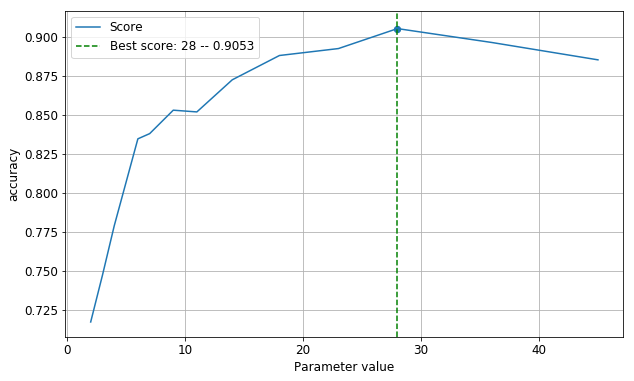

In [213]:
plot_scores(fcnn_best_val_accuracy, split_strategy)

Лучший результат на валидации в окресноти 28 признаков. Протестируем модель.

In [214]:
# Формирование тестовой выборки
best_num_feats = split_strategy[np.argmax(fcnn_best_val_accuracy)]
X_test_importance = torch.FloatTensor(df_X_test[col_importance[:best_num_feats].values].values)

X_test_importance.shape

torch.Size([4027, 28])

Загрузим модель с наибольшим показателем accuracy

In [215]:
fcnn_best_model = torch.load('best_fcnn.pth')
fcnn_best_model.eval()

StandardNet(
  (bn0): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=28, out_features=36, bias=True)
  (act1): ReLU()
  (bn1): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=36, out_features=36, bias=True)
  (act2): ReLU()
  (bn2): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=36, out_features=4, bias=True)
)

In [216]:
f1_nn(fcnn_best_model, X_test_importance, y_test_enc)

f1-score: 0.8302192072410868


**Базовый результат FCNN на 28 признаках: f1-score: 0.830219**

### Ансамбль FCNN

Попробуем улучшить результат обучив ансамбль сетей. Увеличим количество нейронов в слоях, чтобы увеличить переобучение

In [223]:
X = df_X[col_importance[:28].values].values
y = y_enc

In [234]:
ensemble_model = PytorchBaseModel(net_constructor=StandardNet, net_params={'input_len': 28, 'n_neurons': 56},
                              optim_constructor=torch.optim.Adam, optim_params={'lr': 1.0e-3},
                              loss_func=nn.CrossEntropyLoss(), batch_size=73,
                              stop_criterion=7, cuda=False)

In [235]:
ensemble_clf = BaggingClassifier(base_estimator=ensemble_model, n_estimators=10)

In [236]:
ensemble_clf.fit(X, y)

BaggingClassifier(base_estimator=PytorchBaseModel(batch_size=73, cuda=False, loss_func=CrossEntropyLoss(),
         net_constructor=<class '__main__.StandardNet'>,
         net_params={'input_len': 28, 'n_neurons': 56},
         optim_constructor=<class 'torch.optim.adam.Adam'>,
         optim_params={'lr': 0.001}, stop_criterion=7),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [241]:
ens_pred = ensemble_clf.predict(X_test_importance)
f1_score(y_test_enc, ens_pred, average='weighted')

0.8377854499630352

**Ансамбль FCNN на 28 признаках: f1-score: 0.837785**

## Random Forest

In [248]:
rfc = RandomForestClassifier()

In [ ]:
grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000]
}

rsearch_rf = RandomizedSearchCV(rfc,
                                grid,
                                n_iter=20,
                                scoring='f1_weighted',
                                verbose=10e5)

rsearch_rf.fit(X, y)

In [252]:
rsearch_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 50,
 'bootstrap': False}

In [253]:
rsearch_rf.best_score_

0.8580655261082796

In [258]:
rf_clf = clone(rsearch_rf.best_estimator_)

Проверка на тестовой выборке

In [262]:
pred_test = rf_clf.predict(X_test_importance)

In [263]:
f1_rfc_test = f1_score(y_test_enc, pred_test, average='weighted')

print(f'Model test f1 score: {f1_rfc_test}')

Model test f1 score: 0.8555193621605084


Результат гораздо лучше, чем у полносвязной сети

**RF на 28 признаках: f1-score: 0.855519**

### CatBoost

Попробуем градиентный бустинг с базовыми настройками. CatBoost показывается хороший результат "из коробки"

In [271]:
cbc = CatBoostClassifier(logging_level='Silent')
score = cross_validate(cbc, X, y, scoring = 'f1_weighted', cv=StratifiedKFold(n_splits=4))

In [280]:
mean_cv = np.mean(score['test_score'])
print(f'Mean CV for CatBoost: {round(mean_cv, 6)}')

Mean CV for CatBoost: 0.862223


In [281]:
cbc.fit(X, y)

In [284]:
cat_pred = cbc.predict(X_test_importance.numpy())

In [286]:
f1_cbc_test = f1_score(y_test_enc, cat_pred, average='weighted')

print(f'Model test f1 score: {f1_cbc_test}')

Model test f1 score: 0.8668819371067283


**CatBoost на 28 признаках: f1-score: 0.866882**

# Заключение

По результатам исследования информативности представления нарушений сердечного ритма в форме матрицы признаков получен осмысленный и информативный набор признаков, который позволяет эффективно отделять друг от друга характерные события в сигнале ЭКГ, свойственные определенному классу. Проведен тест Тьюки, который подтверждает работоспособность признаков. Были обучены 4 вида моделей машинного обучения:

| **Модель**               |**f1-score**|
|--------------------------|------------|
|Сверточная НС             |**0.857806**|
|Композиция полносвязных НС|0.837785    |
|Случайный лес             |0.855519    |
|Градиентный бустинг       |**0.866882**|

Наилучший результат показал градиентный бустинг. Изначальное предположение о перимуществе сверточной нейронной сети не подтвердилось.

Совершенствование подходов к формированию признакового описания сердечных сокращений в сигнале ЭКГ позволит повысить качество классификации.